# I Motivation


I wanted to understand the cycling landscape in Helsinki from a safety perspective and these datasets made it possible for me. I utilised several datasets cause this is a complex topic that has so many variables. By using these datasets I wanted to offer the end user a well-rounded analysis that covers several topics. I will next present the datasets in question and share the code for all the prep work I did. The prep included e.g. translating Finnish column names and coordinate transformations to work with GeoJSON. Because Dante was working with data that was only available for 2015 and 2022, I limited my analysis (mostly) for the same years.

I initially hoped to have some sort of shape files for the bikelane network from previous years and spent some time in the beginning working with the most resent version. Unfortunately, even after messaging with the data admins, it was not possible to do the project I wished. I am now skipping all that as those files are not contributing to this project in general.

## The datasets 1–4

We have been using several datasets. They are
1. Traffic accidents in Helsinki since 2000
   - https://hri.fi/data/en_GB/dataset/liikenneonnettomuudet-helsingissa
   - this dataset gives me an idea about how has safety in cycling changed in the last decades (if it has)
2. Helsinki postal code areas (later joined with 1)
   - https://hri.fi/data/fi/dataset/paakaupunkiseudun-postinumeroalueet
   - offers me the possibility to do aerial counts and analysis
3. Cyclist counts from automatic counters (two files, 3A counter locations and then 3B the actual counts)
   - https://hri.fi/data/en_GB/dataset/helsingin-pyorailijamaarat
   - to get an idea on whether the cyclist numbers have changed and what appear as popular routes
   - will be looked at together with the accident locations to validate ideas about high traffic areas etc.
   - makes it possible to compare 2015 and 2022
4. Survey data from cycling barometers from years 2016 and 2022
   - https://hri.fi/data/fi/dataset/helsingin-pyorailybarometrikyselyn-vastaukset
   - Options for 2015 were either 2014 or 2016, chose 2016 :)
   - gives statistics from those years, helps to understand if there were changes in 
     - cyclist numbers
     - attitudes
     - main reasons behind why not cycle
     - how big of a problem lack of safety has been / is
5. Walking and cycling zones to public transport
    - https://hri.fi/data/en_GB/dataset/kavely-ja-pyorailyaikavyohykkeet-paakaupunkiseudun-asemille
    - Each entry is a polygon centered around a station, and the area of each polygon represents the access area. The dataset is also split up into 5, 10, and 15 minute increments, then further split by walking and cycling, and finally split again between 2022 and 2015. This dataset also covered the Helsinki Metropolitan area including Espoo and Vantaa.
    - I chose this particular dataset because I hypothesized that the slight decline in cycling could be due to the increase in the amount of public transport available in a short walk. Additionally, I wanted to look at the coverage of public transport available for a reasonable bike ride, as well as the density, between 2015 and 2022 to see if the city had made an active effort to increase the coverage and density of availability of public transport in the city by cycling in particular. Of the data available, I chose to specifically look at 15 minute bike ride coverage and 10 minute walk coverage. I chose 15 minute bike ride because I think someone would reasonably ride 15 minutes to and from their home to a station. Additionally I think any more than 15 minutes and a person would be likely to prefer a car instead. I then chose the 10 minute walk because I believe any more than a 10 minute walk and it's likely that a person would rather use their bycicle, so if there's high density for a 10 minute walk particularly in dense urban areas, these people would be less incentivised to cycle, and if there's low coverage for the less dense areas of Helsinki for a 15 minute bike ride, people would be less
    - My goal for the end user's experience was to have them first look at a map which shows the coverage and density of station access by both a 10 minute walk and a 15 minute bike ride side by side with 2022 and 2015, with the hope that there would be some easily discernable difference between the 2022 and 2015 data. I wanted the user to first see the maps, and potentially try to come to their own conclusion about the data. Additionally since I knew I wanted to use a heatamp with a gradient, I knew some areas might be difficult to tell the difference between numbers close together, so I wanted some way for them to be able to comprehend any questions they might have of the data that are diffult to tell from just a heatmap.

# II Basic stats 

## 1 & 2: Traffic accident data and Helsinki postal code areas

### Prepping 1&2
The goal of the prepping was to
* make the coordinate system GEOjson compatible
* translate it to English
* join the postal code area info

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker


import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import folium 
import json
import math
from math import radians, cos, sin, asin, sqrt
import itertools
import statistics as stats
from statistics import mean
from shapely.wkt import loads

import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap

import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from ipywidgets import interact
from bokeh.models import ColumnDataSource, FactorRange, Select, CustomJS
from bokeh.plotting import output_file, save, figure, show

from bokeh.layouts import gridplot, column
from bokeh.models import ColumnDataSource, Select, Div
from bokeh.plotting import figure, curdoc
from bokeh.io import show
from bokeh.palettes import Category20
from math import ceil
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Category10
from bokeh.transform import dodge
import calendar
from bokeh.models import Div
from bokeh.layouts import column
from bokeh.models import HoverTool
from bokeh.models import Range1d
from bokeh.models import NumeralTickFormatter
from bokeh.models import Label
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Div
from bokeh.transform import dodge
from bokeh.palettes import Category10
from bokeh.models import NumeralTickFormatter
from bokeh.layouts import column



import folium
from folium import FeatureGroup, LayerControl, Marker, Popup, Icon
from folium.plugins import HeatMap



output_notebook()

from folium import plugins

# Set global font
plt.rcParams['font.family'] = 'Georgia'  # Use 'sans-serif', 'monospace', 'cursive', etc.
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.weight'] = 'normal'  # Options: 'light', 'normal', 'bold'
print('Pretty :)')

print('All imported!')

Loading BokehJS ...

Pretty :)
All imported!


In [3]:
#1. Traffic accident data, prep code

df_accidents = pd.read_csv('Maija_data/HKI_traffic_accidents.csv', sep = ';')
df_accidents = df_accidents.dropna(subset=['ita_etrs', 'pohj_etrs'])

# Create geometry from ETRS coordinates
df_accidents['geometry'] = df_accidents.apply(
    lambda row: Point(float(row['ita_etrs']), float(row['pohj_etrs'])),
    axis=1
)

# Convert to GeoDataFrame and update coordinate system
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry='geometry', crs="EPSG:3879")
gdf_accidents_wgs84 = gdf_accidents.to_crs(epsg=4326)

#edit columns
gdf_accidents_wgs84 = gdf_accidents_wgs84.drop(columns = ['pohj_etrs', 'ita_etrs'])
gdf_accidents_wgs84.columns = ['TYPE', 'SEVERITY', 'YEAR', 'geometry']

#translating
translations = {
    'JK':'PEDESTRIAN', 
    'PP': 'BICYCLE',
    'MA':'MOTOR VEHICLE', 
    'MP': 'MOTOR CYCLE'
}
gdf_accidents_wgs84['TYPE'] = gdf_accidents_wgs84['TYPE'].replace(translations)
rows = len(gdf_accidents_wgs84)
years = gdf_accidents_wgs84['YEAR'].unique()
start = years.min()
end = years.max()

print('Traffic accident data has been saved as "df_accidents". Rows with incomplete location data has been removed.\nCoordinate system has been changed to wgs84. Accidents types have been translated.')
print(f'The data has {rows} rows.')

Traffic accident data has been saved as "df_accidents". Rows with incomplete location data has been removed.
Coordinate system has been changed to wgs84. Accidents types have been translated.
The data has 53042 rows.


In [ ]:
#2. Helsinki postal code areas
postal_codes_gdf = gpd.read_file("/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/PKS_Postinumeroalueet_2024.shp")
postal_codes_gdf = postal_codes_gdf.to_crs(epsg=4326)
postal_codes_gdf = postal_codes_gdf.drop(columns = ['Postitoimi', 'PostitoiRU', 'NimiRU', 'Kunta_nro'])
postal_codes_gdf.columns = ['POSTAL CODE', 'NAME', 'CITY', 'geometry' ]

# Step 2: Save to GeoJSON (optional)
postal_codes_gdf.to_file("postal_codes.geojson", driver='GeoJSON') #I had iterations where I showed these areas on the map, for that this is nice

In [ ]:
#Joining 1 and 2 to create a dataset 
gdf_accidents_with_postal = gpd.sjoin(
    gdf_accidents_wgs84,
    postal_codes_gdf[['geometry', 'POSTAL CODE', 'NAME', 'CITY']],
    how='left',
    predicate='within'
)

gdf_accidents_with_postal.head() #this is the prepped dataset that will be used in analysis

### Explorative data analysis with 1&2

*Code below!*

I looked at the areal distributions of the accidents:

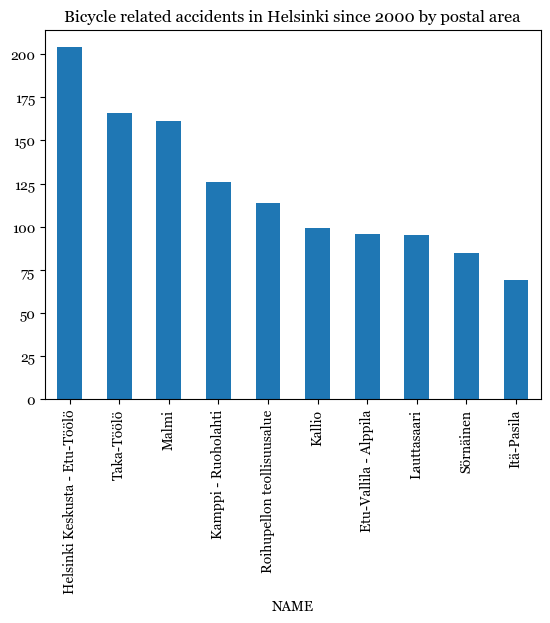

Then I made a more complex one to also visualize that the yearly levels vary a lot...
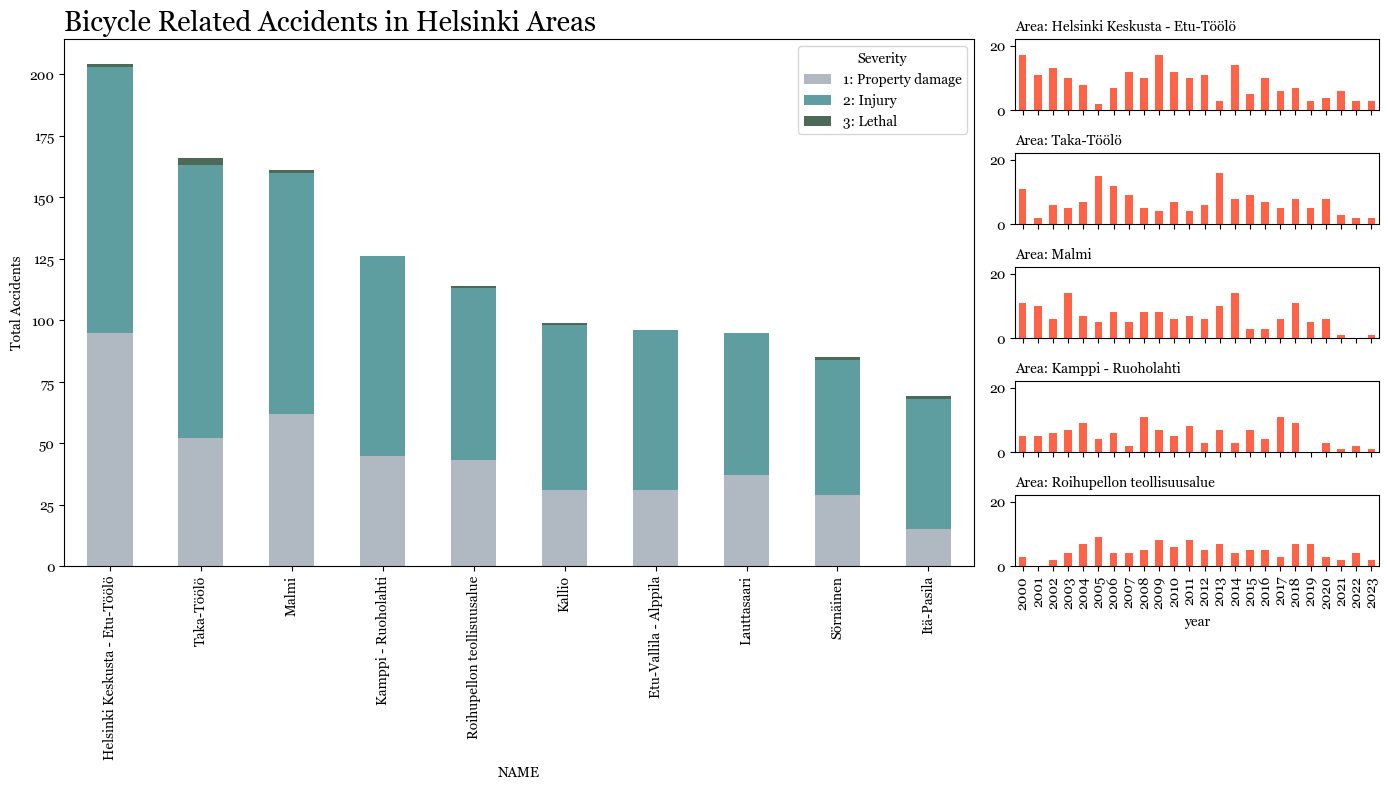

I kinda soon came up with what ended up as a final visualisation as well as it shows the general trend well.
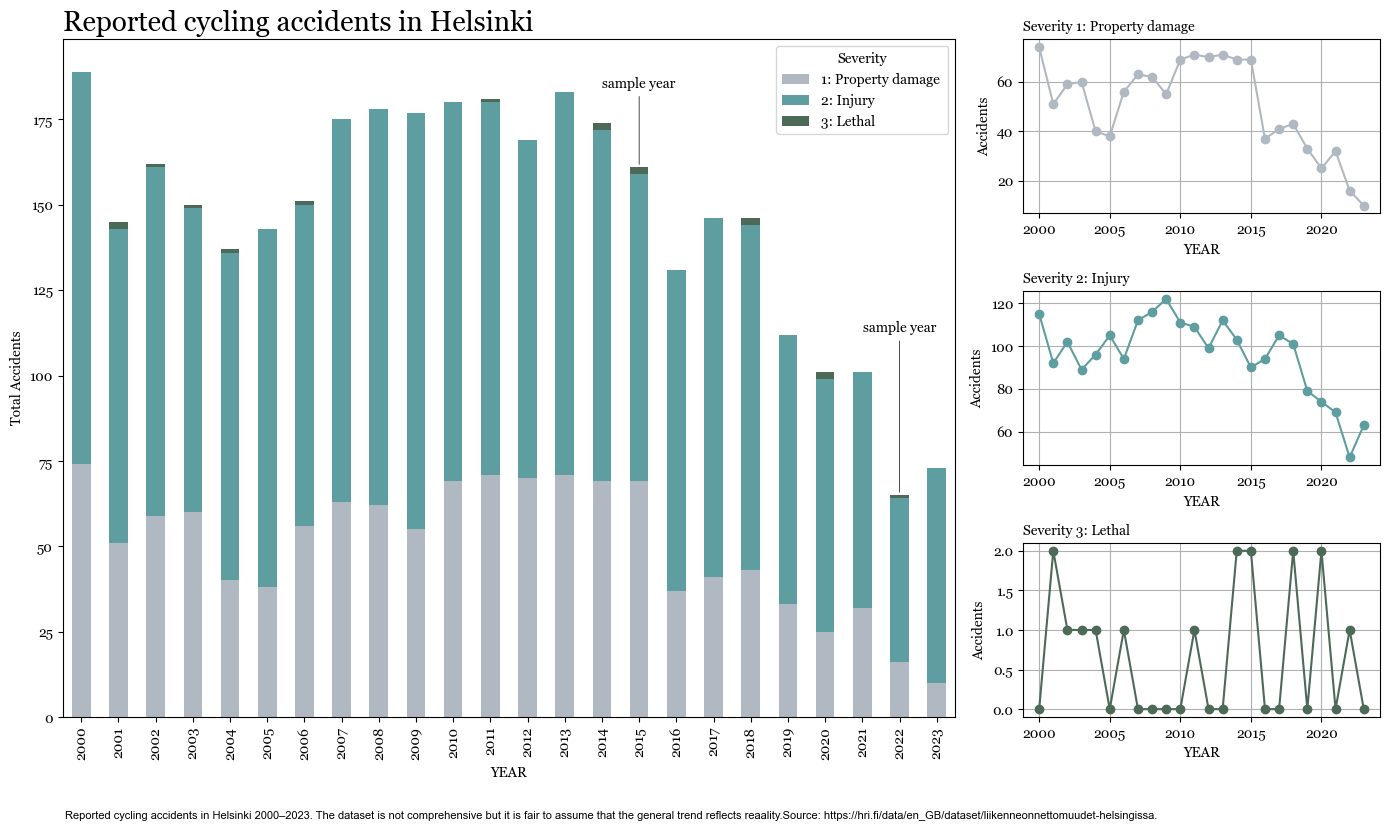

I also did some super simple heatmaps to see where the locations have been taking place. That ended up becoming a key part of the final project so that visualisation will be included there.

In [ ]:
#filtering to cycling only
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('SEVERITY').reset_index().sort_values(by='SEVERITY').reset_index(drop=True)
accident_counts.columns = ['SEVERITY', 'COUNT']
#plot = accident_counts.plot(x = 'SEVERITY', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

years = list(range(2000, 2024))
gdf_accidents_bike = gdf_accidents_bike[gdf_accidents_bike['YEAR'].isin(years)]
gdf_accidents_bike.head()
bike_accidents_amount = len(gdf_accidents_bike)
print(f'The main dataset we will be using has the structure seen below.\nIt includes the postal area information as well as has been filtered to bicycle related accidents only. It has {bike_accidents_amount} rows.')
gdf_accidents_bike.head()

In [ ]:
#Simple areal counts and plotting
areal_counts = gdf_accidents_bike.value_counts('NAME').reset_index()
areal_counts_top10 = areal_counts[0:10]
top_10 = list(areal_counts_top10['NAME'])
top10_gdf = postal_code_areas_gdf[postal_code_areas_gdf['NAME'].isin(top_10)]
plot = areal_counts_top10.plot(x = 'NAME', y = 'count', kind = 'bar', legend = False)
plt.title('Bicycle related accidents in Helsinki since 2000 by postal area')

In [ ]:
#more complex areal count plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define colors
colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']

# --- Accident summary by severity and area (for bar plot) ---
areal_accidents_summary = (
    gdf_accidents_bike
    .groupby(['SEVERITY', 'NAME'])
    .size()
    .unstack(fill_value=0)
)

# Sort areas by total accidents (descending)
sorted_areas = areal_accidents_summary.sum(axis=0).sort_values(ascending=False).index

# Get top 10 and top 5 area names
top_10 = sorted_areas[:10].tolist()
top_5 = sorted_areas[:5].tolist()

# Prepare data for plotting
summary_top10 = areal_accidents_summary[top_10].T  # rows = areas, columns = severity
summary_top5 = areal_accidents_summary[top_5].T

# --- Time series summary by year and area (for line plots) ---
area_year_summary = (
    gdf_accidents_bike
    .groupby(['YEAR', 'NAME'])
    .size()
    .unstack(fill_value=0)
)
shared_ymax = area_year_summary[top_5].max().max()

# --- Create layout ---
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(5, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])
summary_top10.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax_main
)
ax_main.set_title('Bicycle Related Accidents in Helsinki Areas', fontsize=20, loc='left', fontweight='normal')
ax_main.legend(title='Severity', labels=['1: Property damage', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')
ax_main.set_xlabel('NAME')
ax_main.set_xticklabels(summary_top10.index, rotation=90)

# --- Yearly trends for top 5 areas on the right ---
for i, area in enumerate(top_5):
    ax = fig.add_subplot(gs[i, 1])
    area_year_summary[area].plot(
        kind='bar',
        ax=ax,
        color = 'tomato'
    )
    ax.set_title(f"Area: {area}", fontsize=10, loc='left')
    #ax.set_ylabel('Accidents')
    ax.set_ylim(0, shared_ymax + 5)
    ax.grid(False)
    if i < 4:
        ax.set_xticklabels([])  # Hide x-axis labels except for bottom plot
        ax.set_xlabel('')
    else:
        ax.set_xlabel('year')

plt.tight_layout()
plt.show()


In [ ]:
#Yearly changes
#this ended up being the final viz I also used but it was important part of the exploring as well
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('YEAR').reset_index().sort_values(by='YEAR').reset_index(drop=True)
accident_counts.columns = ['YEAR', 'COUNT']
#plot = accident_counts.plot(x = 'YEAR', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']
accidents_summary = gdf_accidents_bike.groupby(['YEAR', 'SEVERITY']).size().unstack(fill_value = 0)
legend_labels=['1: Property damage ', '2: Injury', '3: Lethal']


#creating a layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])  # All 3 rows, column 0
accidents_summary.plot(
    kind='bar',
    stacked=True,
    ylabel = 'Accidents',
    legend = True,
    color = colors,
    ax = ax_main
)
ax_main.set_title('Reported cycling accidents in Helsinki', fontsize=20, loc='left', fontweight = 'normal')
ax_main.legend(title='Severity', labels=['1: Property damage ', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')

#annotating focus years

bar_index_15 = accidents_summary.index.get_loc(2015)
y_val_15 = accidents_summary.loc[2015].sum()
ax_main.annotate(
    'sample year',
    xy = (bar_index_15, y_val_15),
    xytext = (0, 60),
    textcoords = 'offset points',
    arrowprops = dict(facecolor = 'grey',
                      arrowstyle = '-',
                      #connectionstyle = 'arc3, rad=0.1',
                      linewidth = 0.5
                    ),
    fontsize = '10',
    ha = 'center', va = 'center')

bar_index_22 = accidents_summary.index.get_loc(2022)
y_val_22 = accidents_summary.loc[2022].sum()
ax_main.annotate(
    'sample year',
    xy = (bar_index_22, y_val_22),
    xytext = (0, 120),
    textcoords = 'offset points',
    arrowprops = dict(facecolor = 'grey',
                      arrowstyle = '-',
                      #connectionstyle = 'arc3, rad=0.1',
                      linewidth = 0.5
                    ),
    fontsize = '10',
    ha = 'center', va = 'center')

# --- Smaller line plots for each severity level on the right ---
for i, severity in enumerate([1, 2, 3]):
    ax = fig.add_subplot(gs[i, 1])
    accidents_summary[severity].plot(
        kind='line',
        marker='o',
        color=colors[i],
        ax=ax
    )
    ax.set_title(f"Severity {severity}: {legend_labels[i].split(': ')[1]}", fontsize=10, loc='left')
    ax.set_ylabel('Accidents')
    ax.grid(True)


fig.text(
    0.05, -0.02,  # X, Y coordinates in figure space
    "Reported cycling accidents in Helsinki 2000–2023. The dataset is not comprehensive but it is fair to assume that the general trend reflects reaality." \
    "Source: https://hri.fi/data/en_GB/dataset/liikenneonnettomuudet-helsingissa.",
    ha='left', va='top', fontsize=8, fontfamily='Arial'
)
plt.tight_layout()
plt.show()

## 3: Cyclist counters

### Prepping 3

In [ ]:
#3A Cyclist counters: the locations

#reading the csv
counts_locations = pd.read_csv(
    '/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/Helsinki_cyclist_counts_locations.csv',
    sep=';',
    encoding='latin1'  # or 'ISO-8859-1'
)
counts_locations.columns = ['Name', 'x', 'y']

#translating
translations = {
        'Kaisaniemi':'Kaisaniemi',
        'Eteläesplanadi' : 'Eteläesplanadi', 
        'Baana' : 'Baana',
        'Lauttasaaren silta eteläpuoli' : 'Lauttasaari bridge south',
        'Lauttasaaren silta pohjoispuoli' : 'Lauttasaari bridge north',
       'Kulosaaren silta et. sisältää myös pohjoispuolen' : 'Kulosaari both sides',
       'Kuusisaarentie' : 'Kuusisaarentie',
       'Munkkiniemi silta pohjoispuoli' : 'Munkkiniemi bridge north',
       'Munkkiniemen silta eteläpuoli': 'Munkkiniemi bridge south',
       'Heperian puisto (Ooppera)' : 'Hesperia park (the Opera)',
       'Pitkäsilta länsipuoli' : 'Pitkäsilta bridge west',
       'Pitkäsilta itäpuoli' : 'Pitkäsilta bridge east',
       'Merikannontie' : 'Merikannontie',
       'Kulosaaren silta po. suljettu, tietyö' : 'Kulosaari bridge north (closed)',
       'Ratapihantie' : 'Ratapihantie',
       'Huopalahti (asema)' : 'Huopalahti (station)',
       'Kaivokatu' : 'Kaivokatu',
       'Käpylä' : 'Käpylä',
       'Viikintie' : 'Viikintie',
       'Auroransilta' : 'Auroransilta bridge'
}
counts_locations['Name'] = counts_locations['Name'].replace(translations)

#Fixing the coordinates to be geojson ready and exporting 

df = counts_locations
df['x'] = df['x'].astype(str).str.replace(r'\s+', '', regex=True).str.replace(',', '.').astype(float)
df['y'] = df['y'].astype(str).str.replace(r'\s+', '', regex=True).str.replace(',', '.').astype(float)

# Changing coordinate system
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['x'], df['y']),
    crs='EPSG:3879'
)
gdf = gdf.to_crs(epsg=4326)

# Export for future use
gdf.to_file("cycling_counts_locations.geojson", driver="GeoJSON")

# View first rows to feel proud
print(gdf.head())

In [ ]:
#3B Cyclist counters: the counts ;)

#reading the excel
Helsinki_cyclist_counts = pd.read_excel('/Users/maijavalimaki/Desktop/DTU_Social_data_course/helsinki data/Helsinki_cyclist_counts.xlsx')

#translating to match with the locations
columns = Helsinki_cyclist_counts.columns.to_list()
translations = {
        'Date': 'Date',
        'Time': 'Time',
        'Kaisaniemi/Eläintarhanlahti':'Kaisaniemi',
        'Eteläesplanadi' : 'Eteläesplanadi', 
        'Baana' : 'Baana',
        'Lauttasaaren silta eteläpuoli' : 'Lauttasaari bridge south',
        'Lauttasaaren silta pohjoispuoli' : 'Lauttasaari bridge north',
       'Kulosaaren silta et.' : 'Kulosaari both sides',
       'Kuusisaarentie' : 'Kuusisaarentie',
       'Munkkiniemi silta pohjoispuoli' : 'Munkkiniemi bridge north',
       'Munkkiniemen silta eteläpuoli': 'Munkkiniemi bridge south',
       'Hesperian puisto/Ooppera' : 'Hesperia park (the Opera)',
       'Pitkäsilta länsipuoli' : 'Pitkäsilta bridge west',
       'Pitkäsilta itäpuoli' : 'Pitkäsilta bridge east',
       'Merikannontie' : 'Merikannontie',
       'Kulosaaren silta po. ' : 'Kulosaari bridge north (closed)',
       'Ratapihantie' : 'Ratapihantie',
       'Huopalahti (asema)' : 'Huopalahti (station)',
       'Kaivokatu' : 'Kaivokatu',
       'Käpylä - Pohjoisbaana' : 'Käpylä',
       'Viikintie' : 'Viikintie',
       'Auroransilta' : 'Auroransilta bridge'
}

Helsinki_cyclist_counts.rename(columns = translations, inplace = True)
Helsinki_cyclist_counts.to_csv("Cyclist_counts.csv", sep = ';', index = False) #save translation as a csv

### Explorative data analysis 3

First I plotted the yearly numbers to see how they vary. I did a few different graphs.
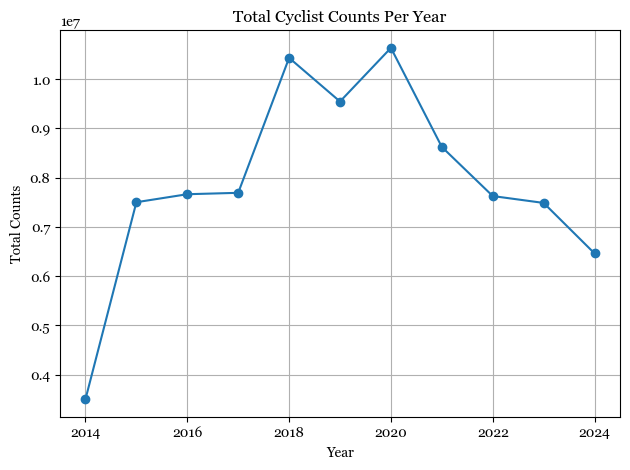
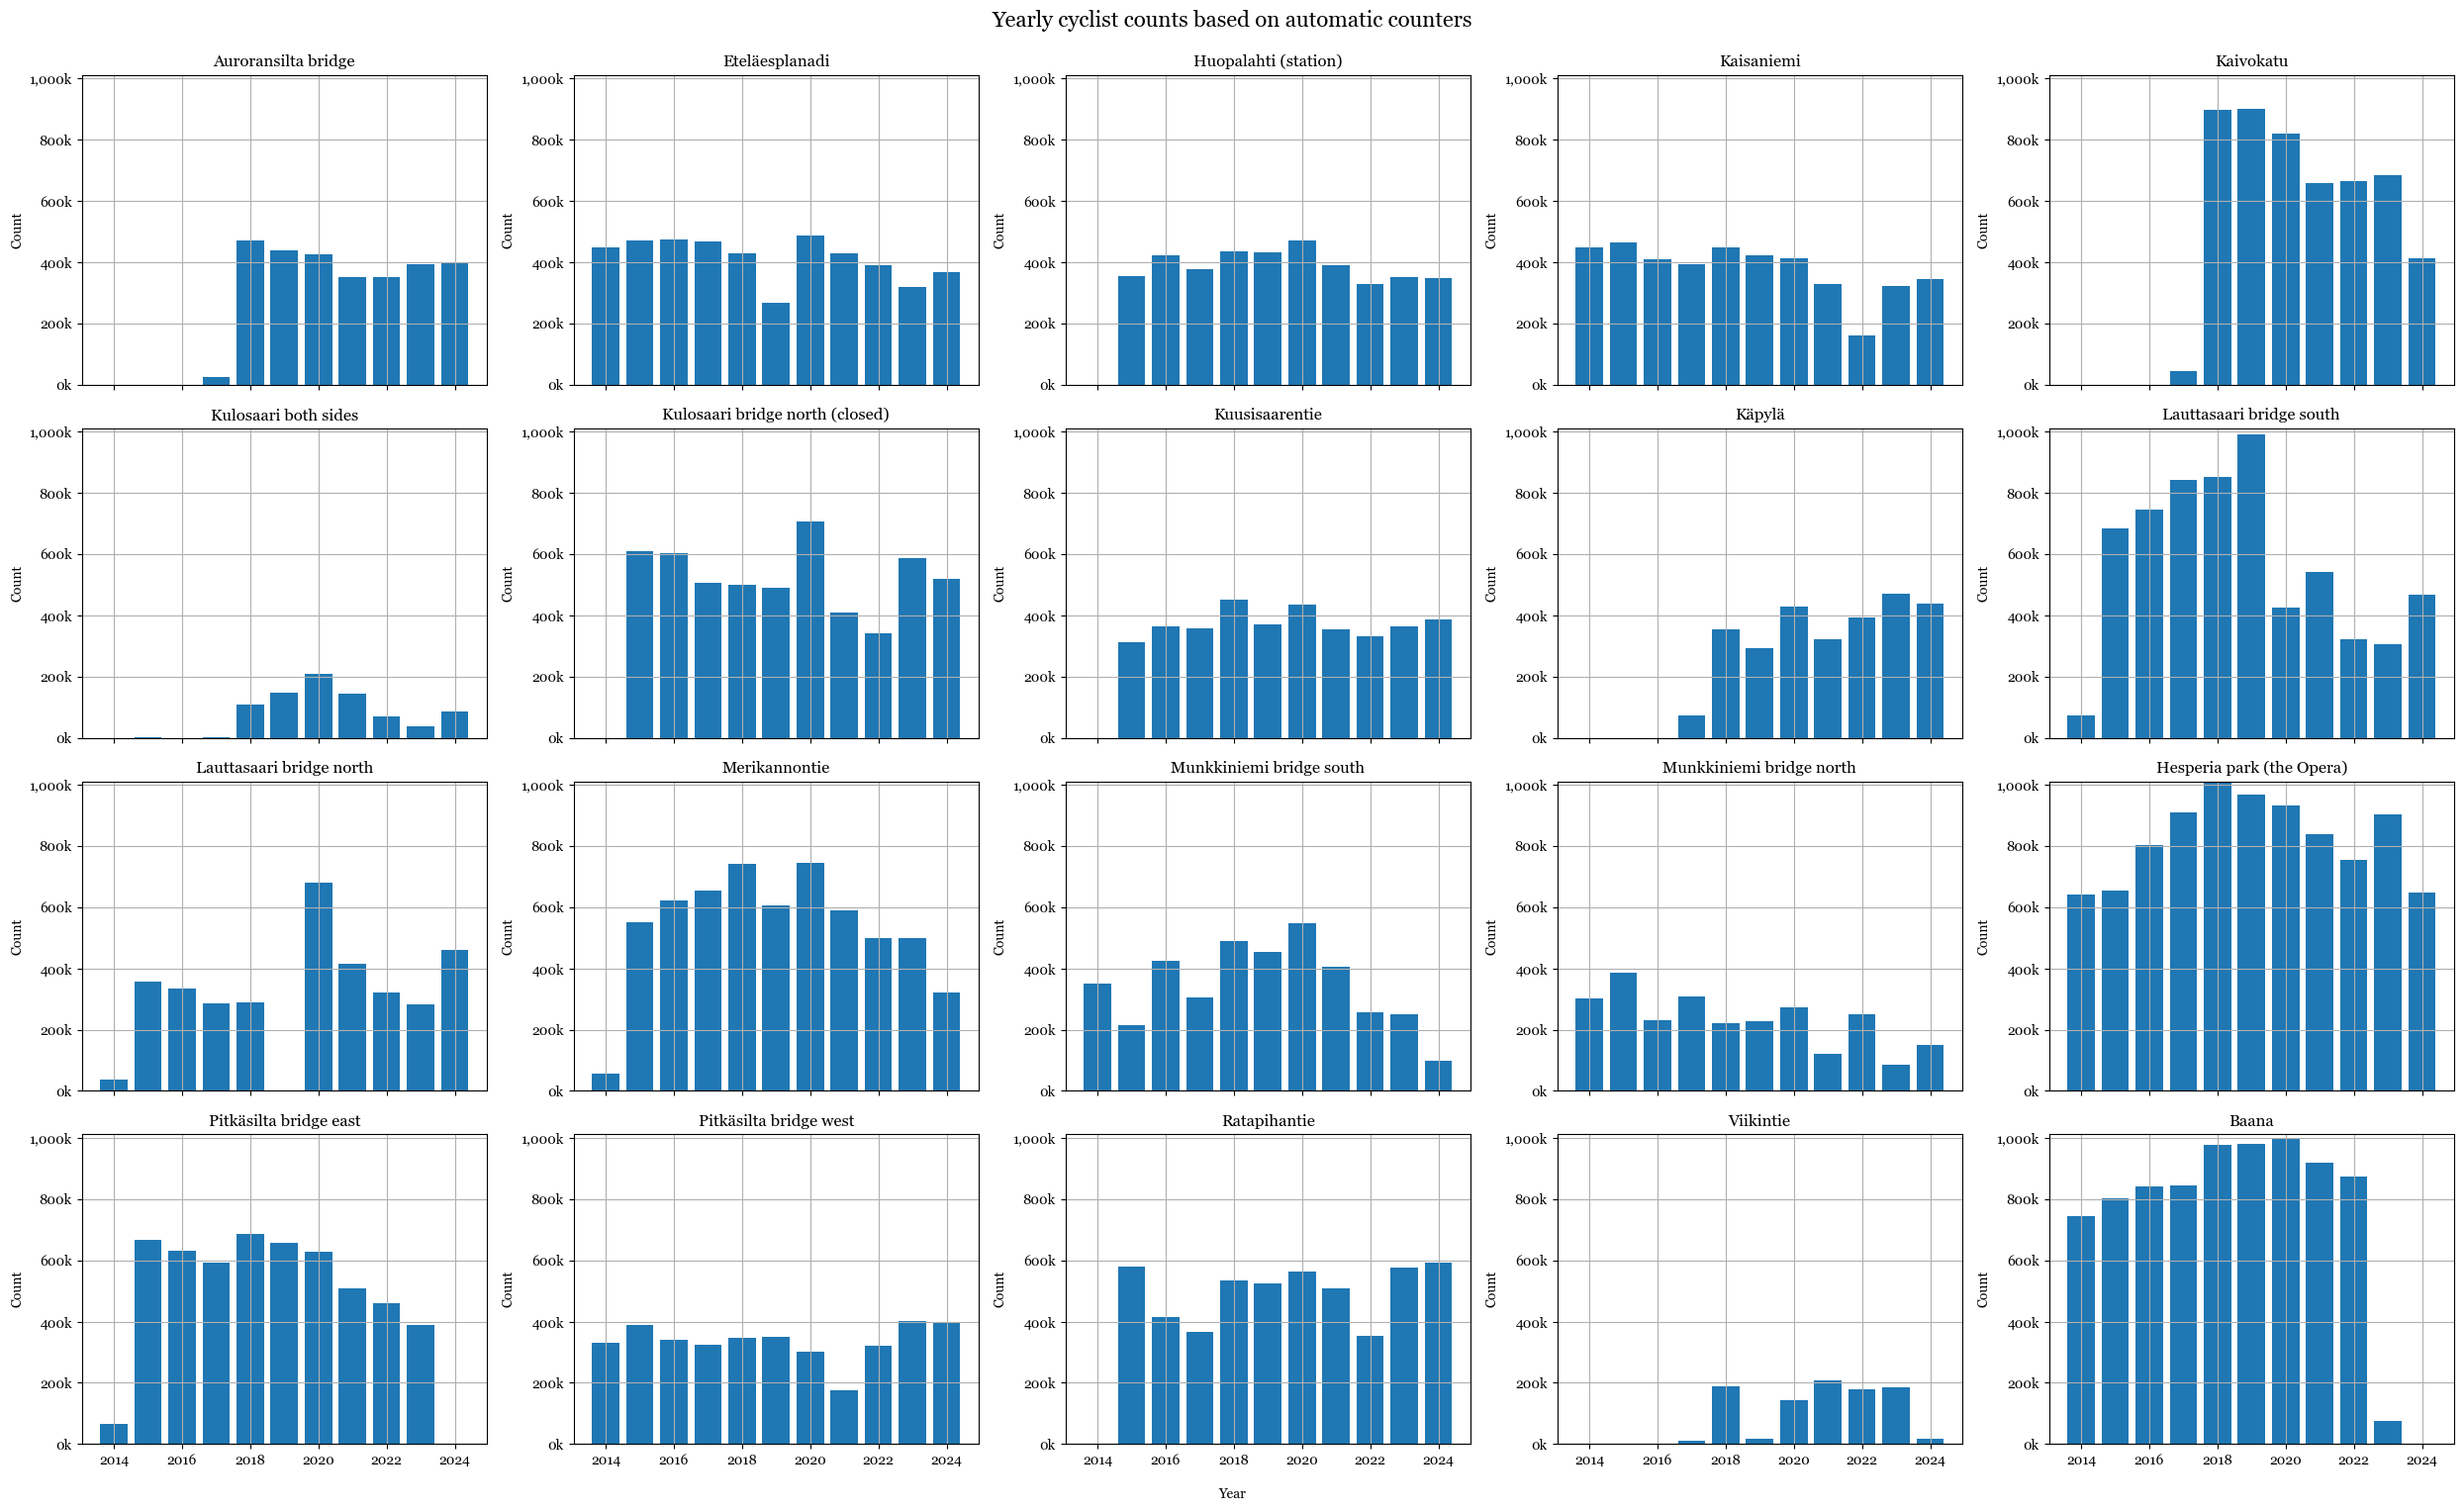
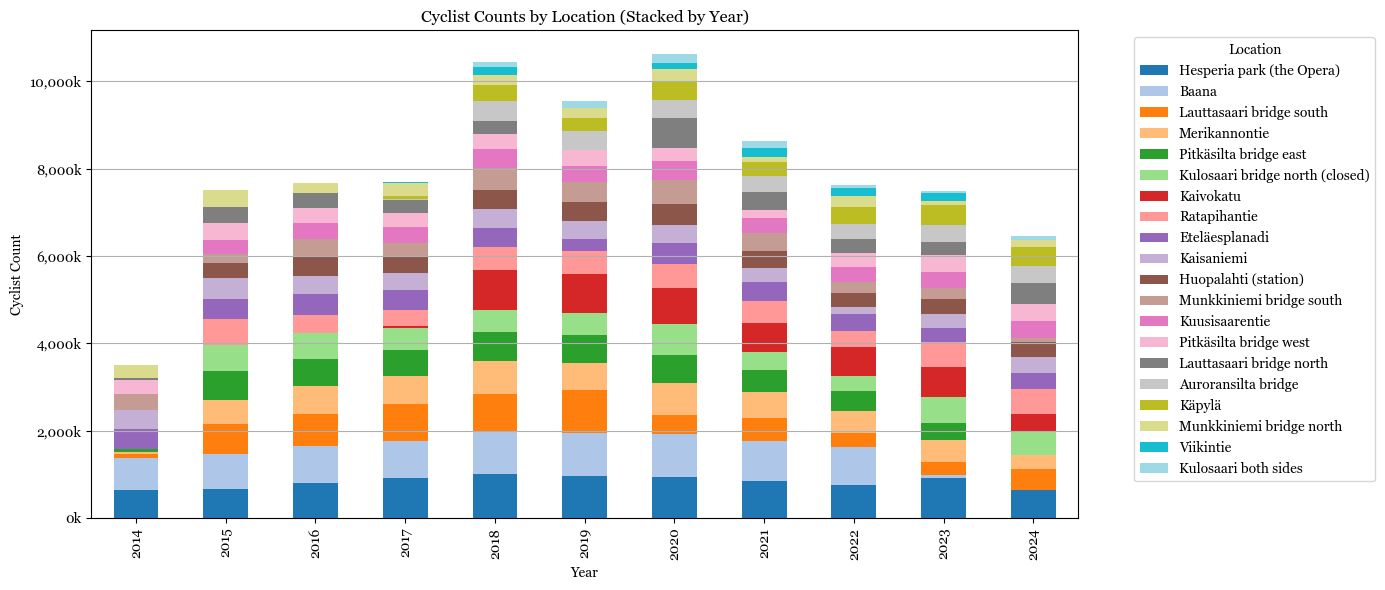

Knowing the city and the locations, it became really evident that this level of visualisation is not useful this data as the counters are sometimes not working for quite some time, which means that comparing the numbers is basically meaningless.

Thus, I plotted the data within the sample years 2015 and 2022 and filtered the locations to ones active on both years. By doing this, I wanted to see if something evident arose right away that would need my attention. There no real surprises and as I am familiar with the city, I know where the central counters are located. But these were nice graphs that insipired me to create the nicer bokeh subplot. 

*Code for everything below!*
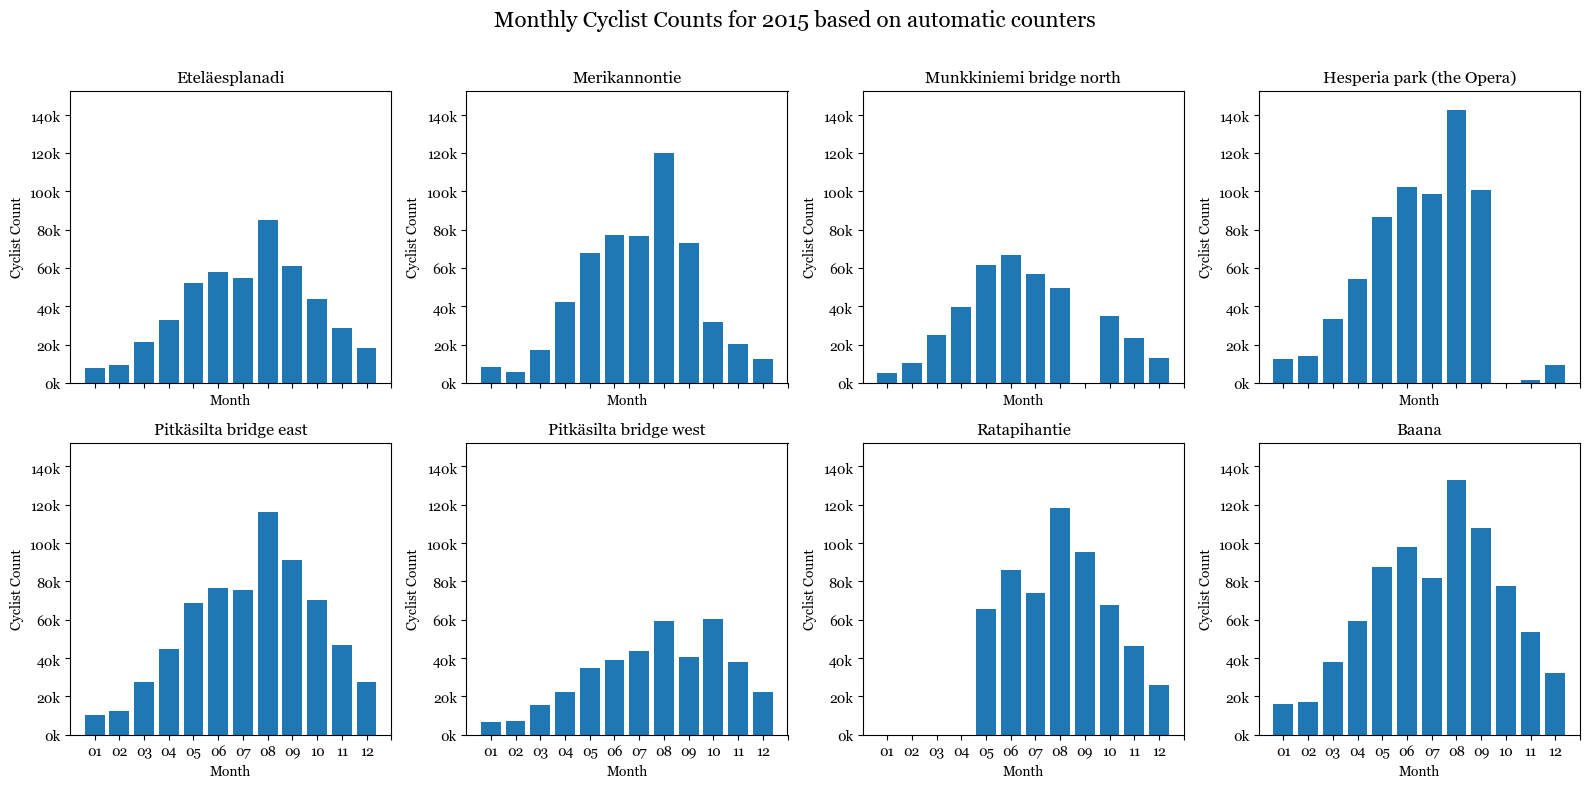
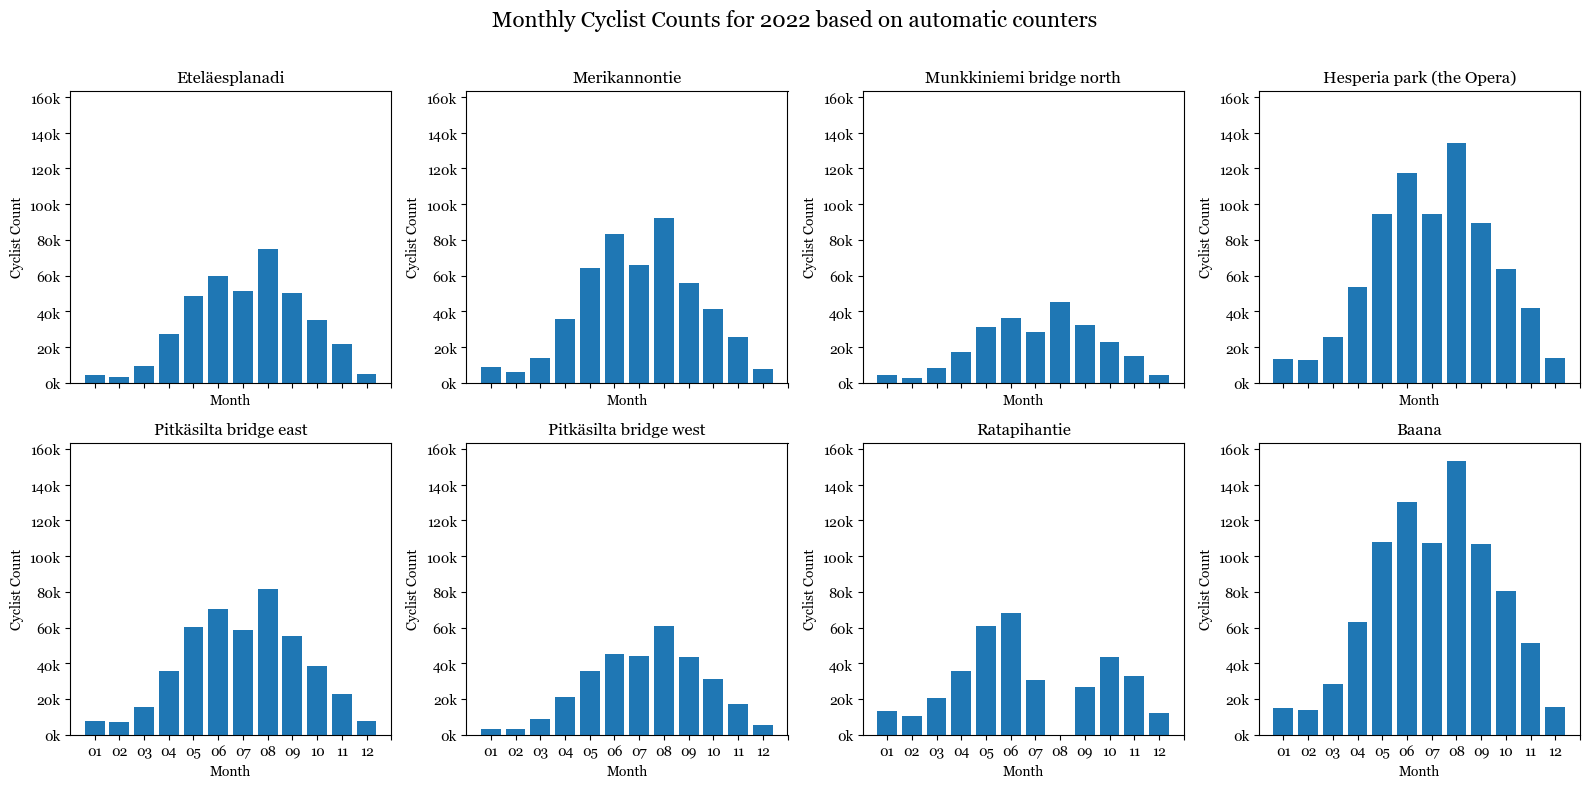

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import folium 
import json
import math
from math import radians, cos, sin, asin, sqrt
import itertools
import statistics as stats
from statistics import mean

import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap

import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from ipywidgets import interact
from bokeh.models import ColumnDataSource, FactorRange, Select, CustomJS
from bokeh.plotting import output_file, save, figure, show

output_notebook()

from folium import plugins

# Set global font
plt.rcParams['font.family'] = 'Georgia'  # Use 'sans-serif', 'monospace', 'cursive', etc.
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.weight'] = 'normal'  # Options: 'light', 'normal', 'bold'
print('Pretty :)')

print('All imported!')

Loading BokehJS ...

Pretty :)
All imported!


In [ ]:
#reading the data and adding month and year columns
df = pd.read_csv('Cyclist_counts.csv', sep = ';')
df['Year'] = df['Date'].str[:4].astype(int)
df['Month'] = df['Date'].str[5:7]
# Reorder columns: put 'Year' first, then the rest
cols = ['Month'] + [col for col in df.columns if col != 'Month']
df = df[cols]
cols = ['Year'] + [col for col in df.columns if col != 'Year']
df = df[cols]
df.head()


In [ ]:
#yearly summary all together
yearly_summary = df.groupby('Year').sum(numeric_only=True)

# Sum across all stations per year
yearly_summary['Total'] = yearly_summary.sum(axis=1)

# Plot
yearly_summary['Total'].plot(kind='line', marker='o')
plt.title("Total Cyclist Counts Per Year")
plt.xlabel("Year")
plt.ylabel("Total Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#stacked bar chart
# Drop 'Total' if present
data = yearly_summary.drop(columns=['Total'], errors='ignore')

# Sort columns by total count across all years (descending)
ordered_cols = data.sum().sort_values(ascending=False).index.tolist()
data = data[ordered_cols]  # Reorder columns

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
data.plot(kind='bar', stacked=True, ax=ax, color=plt.cm.tab20.colors)

# Formatting
ax.set_title("Cyclist Counts by Location (Stacked by Year)")
ax.set_xlabel("Year")
ax.set_ylabel("Cyclist Count")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))
ax.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
#Subplots for locations and yearly summaries
# List of station columns
yearly_summary = yearly_summary.drop(columns=['Total'], errors='ignore')
count_locs = yearly_summary.columns.tolist()


# List of station columns
count_locs = yearly_summary.columns.tolist()

# Get the maximum y value across all stations to standardize y-axis
max_y = yearly_summary[count_locs].max().max()


# Layout: define number of rows and columns
n = len(count_locs)
cols = 5  # Number of columns in the grid
rows = (n + cols - 1) // cols  # Ceiling division to get rows

# Create subplots in a grid
fig, axes = plt.subplots(rows, cols, figsize=(25, 4 * rows), sharex=True)
axes = axes.flatten()  # Flatten in case of a 2D array

# Plot each station
for i, loc in enumerate(count_locs):
    axes[i].bar(yearly_summary.index, yearly_summary[loc])
    axes[i].set_title(loc)
    axes[i].set_ylabel("Count")
    axes[i].set_ylim(0, max_y)  # Set the same y-limit for all plots
    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set common X label
fig.text(0.5, 0.04, 'Year', ha='center')
fig.suptitle(f'Yearly cyclist counts based on automatic counters\n', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [ ]:
#Code to do monthly plots for the chosen locations within a selected year
import matplotlib.pyplot as plt
import pandas as pd

# Select target year

target_year = 2015

df_year = df[df['Year'] == target_year].reset_index(drop=True)

#removing the ones that are not in both datasets
drop_these = ['Auroransilta bridge', 'Kaivokatu', 'Käpylä', 'Viikintie', 'Kulosaari both sides', 'Kulosaari bridge north (closed)', 'Lauttasaari bridge north', 'Lauttasaari bridge south','Kaisaniemi', 'Kuusisaarentie', 'Munkkiniemi bridge south', 'Huopalahti (station)']
df_year = df_year.drop(columns = drop_these, errors='ignore')
# Counter columns (excluding date-related ones)

counter_cols = [col for col in df_year.columns if col not in ['Date', 'Datetime', 'Year', 'Month', 'Time']]
print(counter_cols)

# Group by month and sum
monthly_summary = df_year.groupby('Month')[counter_cols].sum()

# Get the maximum y value across all stations to standardize y-axis
max_y = monthly_summary[counter_cols].max().max()

# Plotting subplots
n = len(counter_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), sharex=True)
axes = axes.flatten()

for i, col in enumerate(counter_cols):
    axes[i].bar(monthly_summary.index, monthly_summary[col])
    axes[i].set_title(col)
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Cyclist Count')
    axes[i].set_xticks(range(0, 13))
    axes[i].set_ylim(0, max_y+10000)  # Set the same y-limit for all plots
    axes[i].yaxis.set_m§jor_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000):,}k'))
    #axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f'Monthly Cyclist Counts for {target_year} based on automatic counters\n', fontsize=16)
plt.tight_layout()
plt.show()




## 4:  Survey data

### Prepping 4

The survey data covers aroun 30 questions and from those I selected the ones I thought related to this projects needs. This included quite some manual labour as I needed to check that the questions were in same columns in both files and what the different values meant. But I got what I needed.

In [2]:
#4 Survey data from 2016 and 2022
#I first saved the excels with the sheet that had just the data as a seperate file.
#I later referred back to og ones for explanations on variable values etc.

data_2016 = pd.read_excel('2016_cycling_survey_data_only.xlsx')
data_2022 = pd.read_excel('2022_cycling_survey_data_only.xlsx')

#I hand picked interesting questions and saved those in seperate dataframes.
#saving interesting data. When I go throught the data analysis, I will show some of the super simple graphs I made.

do_you_cycle = pd.DataFrame() #1 Not at all, 2/3/4 different sections of the year
do_you_cycle['2016'] = data_2016['Aq2']
do_you_cycle['2022'] = data_2022['Aq2']

how_safe = pd.DataFrame() #1	Safe / 2	Quite safe / 3	Quite unsafe / 4	Unsafe / 5	Don't know
how_safe['2016'] = data_2016['Aq7']
how_safe['2022'] = data_2022['Aq7']


with_public_transport = pd.DataFrame() #1	Satisfied / 2	Quite satisfied / 3	Quite unsatisfied / 4	Quite unsatisfied / 5	Don't know
with_public_transport['2016'] = data_2016['Aq12']
with_public_transport['2022'] = data_2022['Aq12']
#with_public_transport.fillna(0, inplace= True)

why_not_cycle = pd.DataFrame() #4 Safety / 5 Preference (public transport, walking, car) / 8 Poor planning
why_not_cycle['2016'] = data_2016['Aq21']
why_not_cycle['2022'] = data_2022['Aq22']

if_better_infra = pd.DataFrame() #1 Yes / 2 No
if_better_infra['2016'] = data_2016['Aq22N1']
if_better_infra['2022'] = data_2022['Aq23N1']

if_safer = pd.DataFrame() #1 Yes / 2 No
if_safer['2016'] = data_2016['Aq22N4']
if_safer['2022'] = data_2022['Aq23N4']

do_you_own_a_bike = pd.DataFrame()
do_you_own_a_bike['2016'] = data_2016['Aj'] #1 No / 2 One / 3 Two / 4 Three or more
do_you_own_a_bike['2022'] = data_2022['Atj'] #1 No / 2 One / 3 Two / 4 Three or more
do_you_own_a_bike['2022 (ebike)'] = data_2022['Atk'] #1 No / 2 Considering / 3 Yes, one / 4 Yes, more than one

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'pd' is not defined

### Explorative analysis 4

After extracting the interesting bits, I did some super simple graphs. Based on these, it became evident that there has been no major changes in the number of people cycling but the reasoning behind why not cycle have changed a bit. These poor graphs help to later focus on the actually interesting bits. For 2016 there were 2004 respondents and for 2022, 2002.
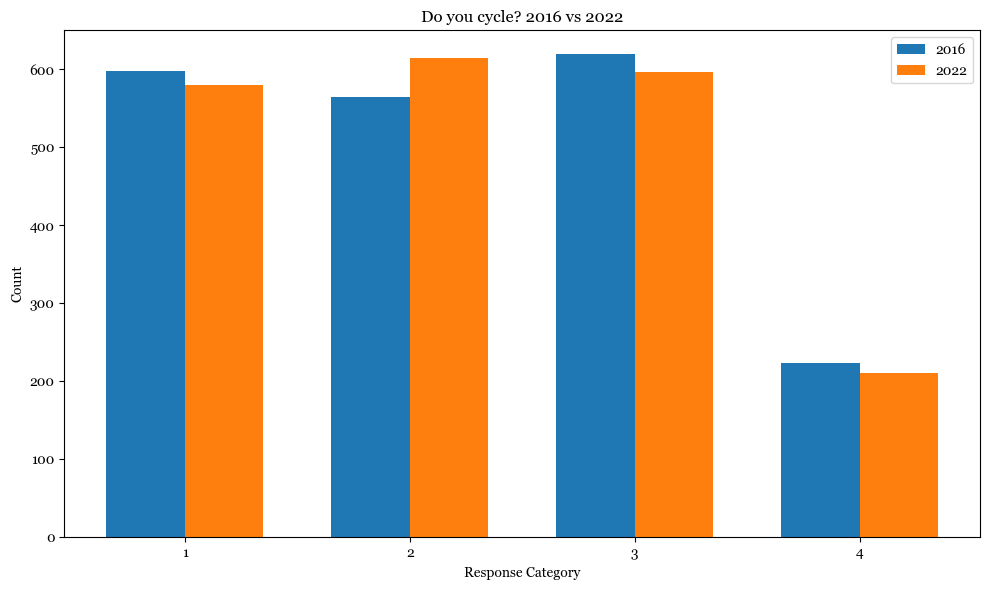
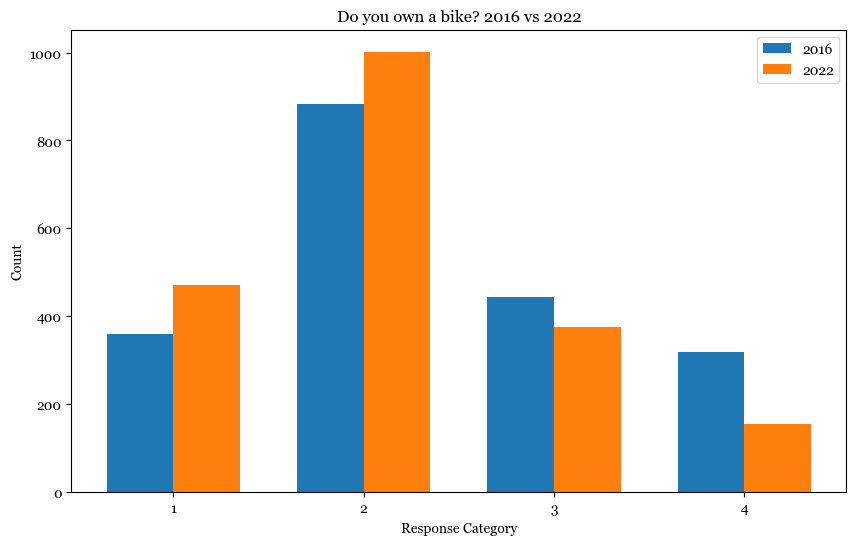
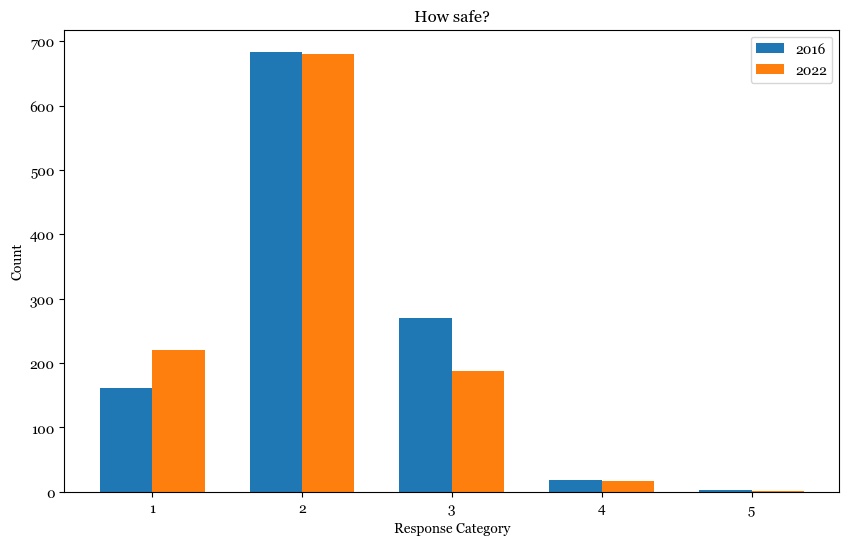
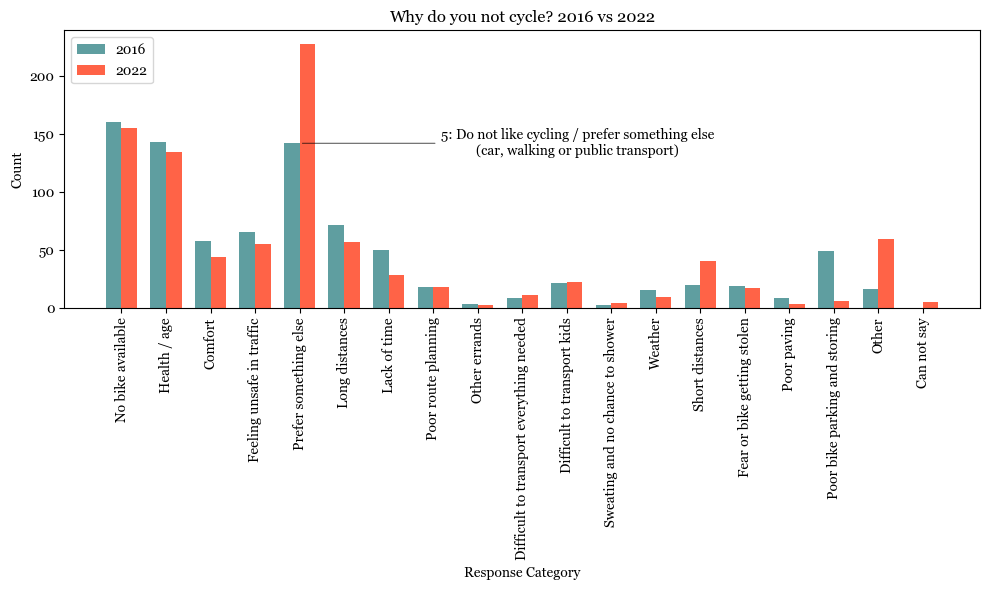
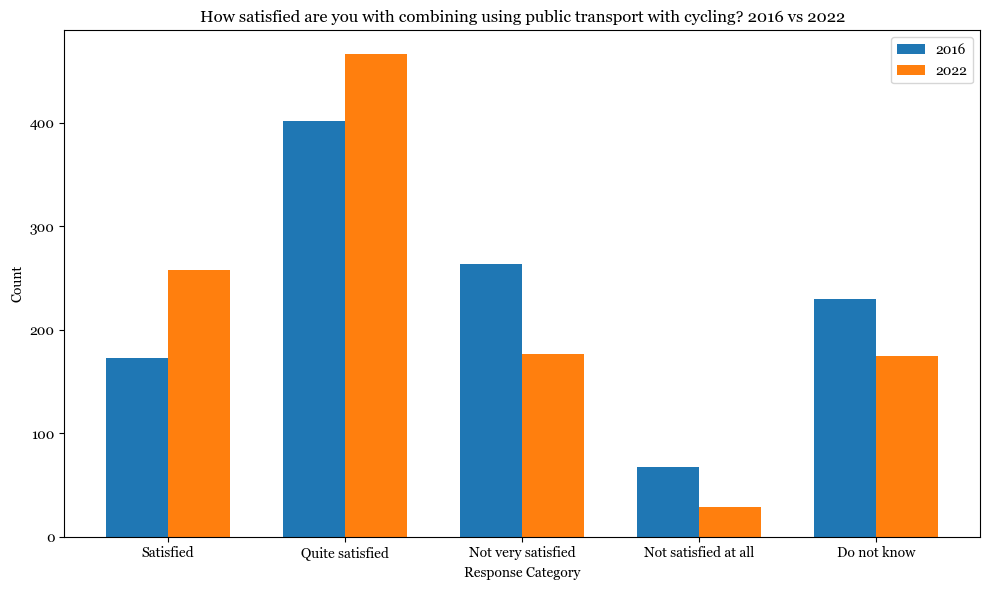

In [ ]:
#Do you cycle?
do_you_cycle_summary = pd.DataFrame()
do_you_cycle_summary['Categories'] = [1, 2, 3, 4]

#counting
counts_2016 = do_you_cycle['2016'].value_counts().reset_index().sort_values(by='2016').reset_index(drop=True)
counts_2022 = do_you_cycle['2022'].value_counts().reset_index().sort_values(by='2022').reset_index(drop=True)

#saving
do_you_cycle_summary['2016'] = counts_2016['count']
do_you_cycle_summary['2022'] = counts_2022['count']


#counting figures
yes16 = sum(do_you_cycle_summary.loc[1:,'2016']) / sum(do_you_cycle_summary['2016']) *100
yes22 = sum(do_you_cycle_summary.loc[1:, '2022']) / sum(do_you_cycle_summary['2022']) * 100

print(f'2016: {yes16}\n2022 : {yes22}')

# Set up bar positions
x = np.arange(len(do_you_cycle_summary['Categories']))  # positions for each category
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot 2016 and 2022 bars
bars_2016 = ax.bar(x - width/2, do_you_cycle_summary['2016'], width, label='2016')
bars_2022 = ax.bar(x + width/2, do_you_cycle_summary['2022'], width, label='2022')

# Customize axes and labels
ax.set_title('Do you cycle? 2016 vs 2022')
ax.set_xlabel('Response Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(do_you_cycle_summary['Categories'])
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#Do you own a bike
do_you_own_a_bike_summary = pd.DataFrame()
do_you_own_a_bike_summary['Categories'] = [1, 2, 3, 4]

#counting
counts_2016 = do_you_own_a_bike['2016'].value_counts().reset_index().sort_values(by='2016').reset_index(drop=True)
counts_2022 = do_you_own_a_bike['2022'].value_counts().reset_index().sort_values(by='2022').reset_index(drop=True)

#saving
do_you_own_a_bike_summary['2016'] = counts_2016['count']
do_you_own_a_bike_summary['2022'] = counts_2022['count']


#counting figures
yes16 = sum(do_you_own_a_bike_summary.loc[1:,'2016']) / sum(do_you_own_a_bike_summary['2016']) *100
yes22 = sum(do_you_own_a_bike_summary.loc[1:, '2022']) / sum(do_you_own_a_bike_summary['2022']) * 100

print(f'2016: {yes16}\n2022 : {yes22}\n2022 (any bike: {yes_any22}')

# Set up bar positions
x = np.arange(len(do_you_own_a_bike_summary['Categories']))  # positions for each category
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot 2016 and 2022 bars
bars_2016 = ax.bar(x - width/2, do_you_own_a_bike_summary['2016'], width, label='2016')
bars_2022 = ax.bar(x + width/2, do_you_own_a_bike_summary['2022'], width, label='2022')

# Customize axes and labels
ax.set_title('Do you own a bike? 2016 vs 2022')
ax.set_xlabel('Response Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(do_you_own_a_bike_summary['Categories'])
ax.legend()

# Show plot
#plt.tight_layout()
#plt.show()

do_you_own_a_bike_summary

In [ ]:
#Do you find cycling safe?

how_safe = pd.DataFrame() #1	Safe / 2	Quite safe / 3	Quite unsafe / 4	Unsafe / 5	Don't know
how_safe['2016'] = data_2016['Aq7']
how_safe['2022'] = data_2022['Aq7']

how_safe_summary = pd.DataFrame()
how_safe_summary['Categories'] = [1, 2, 3, 4, 5] 

#counting
counts_2016 = how_safe['2016'].value_counts().reset_index().sort_values(by='2016').reset_index(drop=True)
counts_2022 = how_safe['2022'].value_counts().reset_index().sort_values(by='2022').reset_index(drop=True)
#counts_e2022 = do_you_own_a_bike['2022 (ebike)'].value_counts().reset_index().sort_values(by='2022 (ebike)').reset_index(drop=True)

#saving
how_safe_summary['2016'] = counts_2016['count']
how_safe_summary['2022'] = counts_2022['count']


#counting figures
yes16 = sum(how_safe_summary.loc[:1,'2016']) / sum(how_safe_summary.loc[:3,'2016']) *100
yes22 = sum(how_safe_summary.loc[:1, '2022']) / sum(how_safe_summary.loc[:3, '2022']) * 100

print(f'2016: {yes16}\n2022 : {yes22}')

# Set up bar positions
x = np.arange(len(how_safe_summary['Categories']))  # positions for each category
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot 2016 and 2022 bars
bars_2016 = ax.bar(x - width/2, how_safe_summary['2016'], width, label='2016')
bars_2022 = ax.bar(x + width/2, how_safe_summary['2022'], width, label='2022')

# Customize axes and labels
ax.set_title('How safe?')
ax.set_xlabel('Response Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(how_safe_summary['Categories'])
ax.legend()

# Show plot
#plt.tight_layout()
#plt.show()

how_safe_summary

In [ ]:
#why not cycle?
why_not_cycle_summary = pd.DataFrame()
why_not_cycle_summary['Categories'] = list(range(1,20))
#why_not_cycle_summary['Category descriptions'] = [#4 Safety / 5 Preference (public transport, walking, car) / 8 Poor planning]

#counting
counts_2016 = why_not_cycle['2016'].value_counts().reset_index().sort_values(by='2016').reset_index(drop=True)
counts_2022 = why_not_cycle['2022'].value_counts().reset_index().sort_values(by='2022').reset_index(drop=True)

#saving
why_not_cycle_summary['2016'] = counts_2016['count']
why_not_cycle_summary['2022'] = counts_2022['count']
#why_not_cycle_summary = why_not_cycle_summary.fillna(0)


#counting figures
in5_16 = sum(why_not_cycle_summary.loc[3:4,'2016']) / why_not_cycle_summary['2016'].sum() * 100
in5_22 = sum(why_not_cycle_summary.loc[3:4, '2022']) / why_not_cycle_summary['2022'].sum() * 100

print(f'Category 5 percentage 2016: {in5_16:.0f}%\nCategory 5 percentage 2022: {in5_22:.0f}%')

#save reasons
reasons = [
    'No bike available',
    'Health / age',
    'Comfort',
    'Feeling unsafe in traffic',
    'Prefer something else',
    'Long distances',
    'Lack of time',
    'Poor route planning',
    'Other errands',
    'Difficult to transport everything needed',
    'Difficult to transport kids',
    'Sweating and no chance to shower',
    'Weather',
    'Short distances',
    'Fear or bike getting stolen',
    'Poor paving',
    'Poor bike parking and storing',
    'Other',
    'Can not say']

why_not_cycle_summary['Reasons'] = reasons
# Set up bar positions
x = np.arange(len(why_not_cycle_summary['Categories']))  # positions for each category
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot 2016 and 2022 bars
bars_2016 = ax.bar(x - width/2, why_not_cycle_summary['2016'], width, label='2016', color = '#5f9ea0')
bars_2022 = ax.bar(x + width/2, why_not_cycle_summary['2022'], width, label='2022', color = 'tomato')

# Customize axes and labels
ax.set_title('Why do you not cycle? 2016 vs 2022')
ax.set_xlabel('Response Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(why_not_cycle_summary['Reasons'], rotation = 90)
ax.legend()

#highlight category 5
# Get the Y value for that
bar_index_5 = why_not_cycle_summary[why_not_cycle_summary['Categories']==5].index[0]
y_val_5 = why_not_cycle_summary.loc[why_not_cycle_summary['Categories']==5, '2016'].values[0]
ax.annotate(
    '5: Do not like cycling / prefer something else\n(car, walking or public transport)',
    xy = (bar_index_5, y_val_5),
    xytext = (200, 0),
    textcoords = 'offset points',
    arrowprops = dict(facecolor = 'grey',
                      arrowstyle = '-',
                      #connectionstyle = 'arc3, rad=0.1',
                      linewidth = 0.5
                    ),
    ha = 'center', va = 'center')


# Show plot
plt.tight_layout()
plt.show()


In [ ]:
#public transport data
mean16 = with_public_transport['2016'].mean()
mean22 = with_public_transport['2022'].mean()

print(f'The means for how satisfied respondest were with joining travelling by public transport and bike are:\n'
      f'2016: {mean16:.2f}\n' \
      f'2022: {mean22:.2f}')

#Do you cycle?
with_public_transport_summary = pd.DataFrame()
with_public_transport_summary['Categories'] = [1, 2, 3, 4, 5]
with_public_transport_summary['Category descriptions'] = ['Satisfied', 'Quite satisfied', 'Not very satisfied', 'Not satisfied at all', 'Do not know']

#counting
counts_2016 = with_public_transport['2016'].value_counts().reset_index().sort_values(by='2016').reset_index(drop=True)
counts_2022 = with_public_transport['2022'].value_counts().reset_index().sort_values(by='2022').reset_index(drop=True)

#saving
with_public_transport_summary['2016'] = counts_2016['count']
with_public_transport_summary['2022'] = counts_2022['count']


#counting figures
yes16 = sum(with_public_transport_summary.loc[1:,'2016']) / sum(with_public_transport_summary['2016']) *100
yes22 = sum(with_public_transport_summary.loc[1:, '2022']) / sum(with_public_transport_summary['2022']) * 100

print(f'At least quite satisfied in 2016: {yes16:.0f}%\nAt least quite satisfied 2022 : {yes22:.0f}%')

# Set up bar positions
x = np.arange(len(with_public_transport_summary['Categories']))  # positions for each category
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot 2016 and 2022 bars
bars_2016 = ax.bar(x - width/2, with_public_transport_summary['2016'], width, label='2016')
bars_2022 = ax.bar(x + width/2, with_public_transport_summary['2022'], width, label='2022')

# Customize axes and labels
ax.set_title('How satisfied are you with combining using public transport with cycling? 2016 vs 2022')
ax.set_xlabel('Response Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(with_public_transport_summary['Category descriptions'])
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


## 5: Walking and cycling zones to public transport

*All code and graphs are under III Data analysis!*
### Write about your choices in data cleaning and preprocessing
One of the choices I made while data cleaning and preprocessing was trying to remove all the cells which were not on land. Because a part of Helsinki is an archipellago, creating a boundary box around the area was not ideal for summary statistics I wanted to gather later on, and I believe it also creates noise in the heatmap I was trying to create. So once I had gottten my grid completed I used an open source shapefile provided by simplemaps which can be found here: https://simplemaps.com/gis/country/fi#all. While this dataset did not have just Helsinki, it did have a shapefile for just the landmass. unfortunately due to the resolution of the shapefile not all of the water cells were removed and actually some land cells were removed, however I believe it's better than nothing.

Another choice I had to make since the dataset used comprised the larger metropolitan area was whether to remove stations in Espoo and Vantaa or just cut off the resulting grid such that stations outside of Helsinki near the border wolud count towards a cell's station access area. I decided to include these stations because although they are not located in Helsinki, It remains a fact that people who reside in a particular cell have access to public transport which increases how far they can get from their residense with a 15 minute bike ride or 10 minute walk to a station.

I also had to make a decision as to the size of the cells I wanted to use. The size of each cell is going to affect the resolution and the way I went about determing a cell's access area was by boundary testing if the centroid of the cell was inside a particular polygon. I went with 250x250m because I felt 175m (the furthest someone could be from the centroid) was a reasonable addition to expect someone to walk without changing their plans. This number most made sense for cyclists which according to the speed useed by the dataset would not increase the time travelled by 1 minute and for walking would increase the time travelled by ~2 minutes.

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis
The dataset contains a lot of cells with 0 stations reacheable. This is true for even the 15 minute bike ride datasets, which have the most coverage, and the 10 minute walk datasets which have much less coverage. Especially the initial grid that I had made. as such, it would be important for me to point this out when I do my anaylis. I initially plotted the raw polygons onto a map to see what the coverage looked like between the two, and these are the conclusions I came to.

# III Data analysis

## Datasets 1–4

In my case this quite overlaps with the previous graphs. I kept working on promising plots to understand better what was going on. Here are some of my key learnings listed.

* 1&2: Traffic accident data and Helsinki postal code areas
    * In general, there are not that many traffic accidents in Helsinki that cause injuries to cyclists and the general trend has been decreasing, which is good
    * By itself, this dataset is a bit random as
      * It includes only the accidents reported to the police, meaning that it is far from comprehensive
      * these accidents appear to be happening in highly trafficked areas, but the reasons for that could be e.g. the other cyclists as well
    * The lethal accidents truly are random as they vary between 0–2 each year
    * the postal areas are not as useful as I expected but still nice

* 3: Cyclist counters
    * I found this dataset very interesting
    * this analysis showed me that cyclists' routes vary due to many things and need critical assessing
    * the within year plots show variance related to e.g. weather. It is also easy to spot if a counter was not functioning at some point.
    * My own experience of the bike traffic decreasing rapidly as July hits was captured in this data!
    * comparing these numbers with the mapped accidents, 'Baana' stands out with its high cyclist counts but lack of accidents. Truly shows how separate infrastructure from cars helps with safety and how cyclists prefer souch routes

* 4: Survey data
    * This a mega complex dataset to which I am only tipping my toes into with my a few question wide sample
    * would be create if the city would gather these findings into a mega dataset which would make it possible to do similar comparative graphs as I did but for many other years
    * People find Helsinki a safer city to cycle in now than they did in 2016
    * Public transport is also seen as fitting better to the mix with cycling, might be due to the metro expansion opening in 2017?
    * Less people own bikes but the number of people cycling has stayed very much the same > could be due to the city bike system being launched in 2015

## Dataset 5

### Describe your data analysis and explain what you've learned about the dataset  

My data analysis included a heatmap of Helsinki and a grouped bar chart with the value counts of all the cells in terms of the plots. I also wanted to include a street map behind the heatmap, since although I wasn't planning on doing it originally, I think it ended up outlining an interesting insight being that most stations are centered around major roadways outside of the city, but realistically most people likely don't live by major roadways. Rather, they likely live near roads that will allow them to get near major roadways. As such somoething Helsinki should do if they want to increasee the amount of people who bike is build more stations that bring people from neighborhoods to these major roadways. Outside of that, I don't think normalizing the dataset made sense so I didn't do any of that. It's also important to note that not every cell contains a residential area-- for example in the top left of the map you can clearly see a park which is near no stations but that's rather irrelevant since most people don't live in parks.

Something I've learned not necessarily about this particular dataset but geospacial data in general is the amount of information that's out there in regards to it, as well as how I can take a large grid and collision test to "shave away" undesirable parts. This is something I'm excited to bring to my job this summer.

**The entire process of prepping, analysing and creating the visualisations is below.**

### Code used in analysis

In [ ]:
import geopandas as gpd
import json
import plotly.express as px
import math
import numpy as np
import pandas as pd
from shapely.geometry import box

gdf_15_bike_2022 = gpd.read_file(f"Dante_data/15min_pyoraily.shp").to_crs("EPSG:4326")

#### 15 min cycling

In [ ]:
# create an 1kmx1km grid encompassing Helsinki

# bounding box
lon_min, lon_max, lat_min, lat_max = 24.84263, 25.2000, 60.14507, 60.27695

# creating grid
mean_lat = (lat_min + lat_max) / 2.0
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(mean_lat))

# we want to do half a kilometer
lat_step = 1.0 / km_per_deg_lat / 4
lon_step = 1.0 / km_per_deg_lon / 4

lons = np.arange(lon_min, lon_max, lon_step)
lats = np.arange(lat_min, lat_max, lat_step)

cells = []
for lon in lons:
  for lat in lats:
    cells.append(box(lon, lat, lon + lon_step, lat + lat_step))

grid = gpd.GeoDataFrame(geometry=cells, crs="EPSG:4326")


In [ ]:
# boundary check each box on the polygons and count the number of hits
centers = grid.copy()
centers.geometry = centers.geometry.centroid
spacial_join =  gpd.sjoin(centers,        
                          gdf_15_bike_2022,            
                          how='inner',
                          predicate='within')
counts = spacial_join.groupby(spacial_join.index).size()

# assign that number of hits to that box
grid['count'] = counts.reindex(grid.index, fill_value=0)

In [ ]:
# get land polygon
finland = gpd.read_file("Dante_data/fi.json").to_crs(epsg=4326)

# getting centroid
centroids = grid.copy()
centroids.geometry = centroids.geometry.centroid
spacial_join_land = gpd.sjoin(centroids,
                              finland,
                              how='inner',
                              predicate='within')


grid = grid.iloc[spacial_join_land.index].reset_index(inplace=False).rename(columns={'index': 'grid_id'})
grid_json = json.loads(grid.to_json())

In [ ]:
# 7) Plot with Plotly Express
fig_15min_bike_2022 = px.choropleth_mapbox(
    grid,
    geojson=grid_json,
    locations='grid_id',
    featureidkey='properties.grid_id',
    color='count',
    color_continuous_scale="Viridis",
    range_color=[0, 12],
    center={'lat': mean_lat, 'lon': (lon_min + lon_max) / 2.0},
    mapbox_style="open-street-map",
    zoom=10.20,
    opacity=0.3,
    hover_data=['count'],
    labels={'count':'# stations'},
    width=750,
    height=500
)

fig_15min_bike_2022.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_15min_bike_2022.update_traces(marker_line_width=0.1)
fig_15min_bike_2022.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},   # add some top margin for title
    title={
        'text': "Number of Stations Reachable by 15 Minute Bike Ride in 250x250m Quadrants in 2022",
        'x': 0,
        'xanchor': 'left'
    }
)
fig_15min_bike_2022.show(config={'scrollZoom':True})
bike_15min_2022_counts = grid['count'].value_counts()

I wanted to include a bar plot with the x axis being the count variable of the grid dataframe and the y variable being the number of occurances of x count, but due to the poor graphical data resolution of the Helsinki datafile this statistic would not be meaningful. Another solution might have been to remove the cells which had 0 stops in the service area, but for smaller networks such as "bus stops/train stations 5 minute walk coverage" this would likely result in the removal of large parts of the dataset, defeating the purpose of the analysis.

In [ ]:
gdf_15_bike_2015 = gpd.read_file(f"Dante_data/15min_bike.shp").to_crs("EPSG:4326")

# create an 1kmx1km grid encompassing Helsinki

# bounding box
lon_min, lon_max, lat_min, lat_max = 24.84263, 25.2000, 60.14507, 60.27695

# creating grid
mean_lat = (lat_min + lat_max) / 2.0
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(mean_lat))

# we want to do half a kilometer
lat_step = 1.0 / km_per_deg_lat / 4
lon_step = 1.0 / km_per_deg_lon / 4

lons = np.arange(lon_min, lon_max, lon_step)
lats = np.arange(lat_min, lat_max, lat_step)

cells = []
for lon in lons:
  for lat in lats:
    cells.append(box(lon, lat, lon + lon_step, lat + lat_step))

grid = gpd.GeoDataFrame(geometry=cells, crs="EPSG:4326")


# boundary check each box on the polygons and count the number of hits
centers = grid.copy()
centers.geometry = centers.geometry.centroid
spacial_join =  gpd.sjoin(centers,        
                          gdf_15_bike_2015,            
                          how='inner',
                          predicate='within')
counts = spacial_join.groupby(spacial_join.index).size()

# assign that number of hits to that box
grid['count'] = counts.reindex(grid.index, fill_value=0)


# get land polygon
finland = gpd.read_file("Dante_data/fi.json").to_crs(epsg=4326)

# getting centroid
centroids = grid.copy()
centroids.geometry = centroids.geometry.centroid
spacial_join_land = gpd.sjoin(centroids,
                              finland,
                              how='inner',
                              predicate='within')


grid = grid.iloc[spacial_join_land.index].reset_index(inplace=False).rename(columns={'index': 'grid_id'})
grid_json = json.loads(grid.to_json())


# 7) Plot with Plotly Express
fig_bike_15min_2015 = px.choropleth_mapbox(
    grid,
    geojson=grid_json,
    locations='grid_id',
    featureidkey='properties.grid_id',
    color='count',
    color_continuous_scale="Viridis",
    range_color=[0, 12],
    center={'lat': mean_lat, 'lon': (lon_min + lon_max) / 2.0},
    mapbox_style="open-street-map",
    zoom=10.15,
    opacity=0.3,
    hover_data=['count'],
    labels={'count':'# stations'},
    width=750,
    height=500
)

fig_bike_15min_2015.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_bike_15min_2015.update_traces(marker_line_width=0.1)
fig_bike_15min_2015.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},   # add some top margin for title
    title={
        'text': "Number of Stations Reachable by 15 Minute Bike Ride in 250x250m Quadrants in 2015",
        'x': 0,
        'xanchor': 'left'
    }
)
fig_bike_15min_2015.show(config={'scrollZoom':True})
bike_15min_2015_counts = grid['count'].value_counts()
# need to do this to keep x axis the same
bike_15min_2015_counts[11] = 0
bike_15min_2015_counts[12] = 0

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=['2015', '2022'],
    shared_yaxes=True,
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]]
)

# adding the graphs
for trace in fig_bike_15min_2015.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig_15min_bike_2022.data:
    fig.add_trace(trace, row=1, col=2)


fig.update_layout(
    mapbox1=fig_bike_15min_2015.layout.mapbox,  # settings from the first
    mapbox2=fig_15min_bike_2022.layout.mapbox,  # settings from the second
    mapbox1_domain={"x": [0.0, 0.499], "y": [0, 1]},
    mapbox2_domain={"x": [0.501, 1.0], "y": [0, 1]},
    width=1350,
    height=500,
    coloraxis=dict(
        colorscale="Viridis",
        cmin=0,
        cmax=12,
    ),
    title={
        'text': "Number of Stations Reachable by 15 Minute Bike Ride in 250x250m Quadrants 2015 vs 2022",
        'x': 0.5,
        'xanchor': 'center'
    },
    margin={"l":0,"r":0,"t":40,"b":0}
)
fig.show(config={'scrollZoom':True})
fig.write_html("bike_15min_map.html", include_plotlyjs="cdn", full_html=True)

In [ ]:
df = pd.DataFrame({
    'count':    list(bike_15min_2015_counts.values) + list(bike_15min_2022_counts.values),
    'stations': list(bike_15min_2015_counts.index)  + list(bike_15min_2022_counts.index),
    'year':     ['2015'] * len(bike_15min_2015_counts) + ['2022'] * len(bike_15min_2022_counts)
})


fig = px.bar(
    df,
    x='stations',
    y='count',
    color='year',
    barmode='group',
    text_auto=True,
    labels={'stations':'Number of Stations Reachable','count':'Occurences'},
    width=1350
)

for trace in fig.data:
    if trace.name == '2015':
        trace.marker.color = 'lightgrey'
    elif trace.name == '2022':
        trace.marker.color = 'darkcyan'

fig.update_layout(
    title="Occurrences of Stations Reachable by 15 Minute Bike Ride in a 250x250km Grid of Helsinki",
    legend_title="Year"
)
fig.update_xaxes(
    tickmode='linear',
    dtick=1
)
fig.show()
fig.write_html("bike_15min_counts.html", include_plotlyjs="cdn", full_html=True)

In [ ]:
fig.write_html("bike_15min_counts.html", include_plotlyjs="cdn", full_html=True)

#### 15 min walking

In [ ]:
gdf_10_walk_2022 = gpd.read_file(f"Dante_data/10min_kavely.shp").to_crs("EPSG:4326")

# create an 1kmx1km grid encompassing Helsinki

# bounding box
lon_min, lon_max, lat_min, lat_max = 24.84263, 25.2000, 60.14507, 60.27695

# creating grid
mean_lat = (lat_min + lat_max) / 2.0
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(mean_lat))

# we want to do half a kilometer
lat_step = 1.0 / km_per_deg_lat / 4
lon_step = 1.0 / km_per_deg_lon / 4

lons = np.arange(lon_min, lon_max, lon_step)
lats = np.arange(lat_min, lat_max, lat_step)

cells = []
for lon in lons:
  for lat in lats:
    cells.append(box(lon, lat, lon + lon_step, lat + lat_step))

grid = gpd.GeoDataFrame(geometry=cells, crs="EPSG:4326")


# boundary check each box on the polygons and count the number of hits
centers = grid.copy()
centers.geometry = centers.geometry.centroid
spacial_join =  gpd.sjoin(centers,        
                          gdf_10_walk_2022,            
                          how='inner',
                          predicate='within')
counts = spacial_join.groupby(spacial_join.index).size()

# assign that number of hits to that box
grid['count'] = counts.reindex(grid.index, fill_value=0)


# get land polygon
finland = gpd.read_file("Dante_data/fi.json").to_crs(epsg=4326)

# getting centroid
centroids = grid.copy()
centroids.geometry = centroids.geometry.centroid
spacial_join_land = gpd.sjoin(centroids,
                              finland,
                              how='inner',
                              predicate='within')


grid = grid.iloc[spacial_join_land.index].reset_index(inplace=False).rename(columns={'index': 'grid_id'})
grid_json = json.loads(grid.to_json())


# 7) Plot with Plotly Express
fig_walk_10min_2022 = px.choropleth_mapbox(
    grid,
    geojson=grid_json,
    locations='grid_id',
    featureidkey='properties.grid_id',
    color='count',
    color_continuous_scale="Viridis",
    center={'lat': mean_lat, 'lon': (lon_min + lon_max) / 2.0},
    mapbox_style="open-street-map",
    zoom=10.15,
    opacity=0.3,
    hover_data=['count'],
    labels={'count':'# stations'},
    width=750,
    height=500
)

fig_walk_10min_2022.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_walk_10min_2022.update_traces(marker_line_width=0.1)
fig_walk_10min_2022.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},   # add some top margin for title
    title={
        'text': "Number of Stations Reachable by 10 Minute Walk in 250x250m Quadrants in 2022",
        'x': 0,
        'xanchor': 'left'
    }
)
fig_walk_10min_2022.show(config={'scrollZoom':True})
walk_10min_2022_counts = grid['count'].value_counts()

In [ ]:
gdf_10_walk_2015 = gpd.read_file(f"Dante_data/10min_Walk.shp").to_crs("EPSG:4326")

# create an 1kmx1km grid encompassing Helsinki

# bounding box
lon_min, lon_max, lat_min, lat_max = 24.84263, 25.2000, 60.14507, 60.27695

# creating grid
mean_lat = (lat_min + lat_max) / 2.0
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(mean_lat))

# we want to do half a kilometer
lat_step = 1.0 / km_per_deg_lat / 4
lon_step = 1.0 / km_per_deg_lon / 4

lons = np.arange(lon_min, lon_max, lon_step)
lats = np.arange(lat_min, lat_max, lat_step)

cells = []
for lon in lons:
  for lat in lats:
    cells.append(box(lon, lat, lon + lon_step, lat + lat_step))

grid = gpd.GeoDataFrame(geometry=cells, crs="EPSG:4326")


# boundary check each box on the polygons and count the number of hits
centers = grid.copy()
centers.geometry = centers.geometry.centroid
spacial_join =  gpd.sjoin(centers,        
                          gdf_10_walk_2015,            
                          how='inner',
                          predicate='within')
counts = spacial_join.groupby(spacial_join.index).size()

# assign that number of hits to that box
grid['count'] = counts.reindex(grid.index, fill_value=0)


# get land polygon
finland = gpd.read_file("Dante_data/fi.json").to_crs(epsg=4326)

# getting centroid
centroids = grid.copy()
centroids.geometry = centroids.geometry.centroid
spacial_join_land = gpd.sjoin(centroids,
                              finland,
                              how='inner',
                              predicate='within')


grid = grid.iloc[spacial_join_land.index].reset_index(inplace=False).rename(columns={'index': 'grid_id'})
grid_json = json.loads(grid.to_json())


# 7) Plot with Plotly Express
fig_walk_10min_2015 = px.choropleth_mapbox(
    grid,
    geojson=grid_json,
    locations='grid_id',
    featureidkey='properties.grid_id',
    color='count',
    color_continuous_scale="Viridis",
    center={'lat': mean_lat, 'lon': (lon_min + lon_max) / 2.0},
    mapbox_style="open-street-map",
    zoom=10.15,
    opacity=0.3,
    hover_data=['count'],
    labels={'count':'# stations'},
    width=750,
    height=500
)

fig_walk_10min_2015.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_walk_10min_2015.update_traces(marker_line_width=0.1)
fig_walk_10min_2015.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},   # add some top margin for title
    title={
        'text': "Number of Stations Reachable by 10 Minute Walk in 250x250m Quadrants in 2015",
        'x': 0,
        'xanchor': 'left'
    }
)
fig_walk_10min_2015.show(config={'scrollZoom':True})
walk_10min_2015_counts = grid['count'].value_counts()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=['2015', '2022'],
    shared_yaxes=True,
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]]
)

# adding the graphs
for trace in fig_walk_10min_2015.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig_walk_10min_2022.data:
    fig.add_trace(trace, row=1, col=2)


fig.update_layout(
    mapbox1=fig_bike_15min_2015.layout.mapbox,  # settings from the first
    mapbox2=fig_15min_bike_2022.layout.mapbox,  # settings from the second
    mapbox1_domain={"x": [0.0, 0.499], "y": [0, 1]},
    mapbox2_domain={"x": [0.501, 1.0], "y": [0, 1]},
    width=1350,
    height=500,
    coloraxis=dict(
        colorscale="Viridis",
    ),
    title={
        'text': "Number of Stations Reachable by 10 Minute Walk in 250x250m Quadrants 2015 vs 2022",
        'x': 0.5,
        'xanchor': 'center'
    },
    margin={"l":0,"r":0,"t":40,"b":0}
)
fig.show(config={'scrollZoom':True})
fig.write_html("walk_10_min_map.html", include_plotlyjs="cdn", full_html=True)

In [ ]:
df = pd.DataFrame({
    'count':    list(walk_10min_2015_counts.values) + list(walk_10min_2022_counts.values),
    'stations': list(walk_10min_2015_counts.index)  + list(walk_10min_2022_counts.index),
    'year':     ['2015'] * len(walk_10min_2015_counts) + ['2022'] * len(walk_10min_2022_counts)
})


fig = px.bar(
    df,
    x='stations',
    y='count',
    color='year',
    barmode='group',
    text_auto=True,
    labels={'stations':'Number of Stations Reachable','count':'Occurences'},
    width=1350
)

for trace in fig.data:
    if trace.name == '2015':
        trace.marker.color = 'lightgrey'
    elif trace.name == '2022':
        trace.marker.color = 'darkcyan'

fig.update_layout(
    title="Occurrences of Stations Reachable by 10 Minute Walk in a 250x250km Grid of Helsinki",
    legend_title="Year"
)
fig.update_xaxes(
    tickmode='linear',
    dtick=1
)
fig.show()
fig.write_html("walk_10min_counts.html", include_plotlyjs="cdn", full_html=True)

# IV Genre

The genre is magazine style.

#### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

* ##### Visual structuring:Consistent Visual Platform
  I opted for consistent colors and had distinctive colors for 2015(/2016) and 2022. Could've improved this even more I think. Same goes for the chosen font. This helps with credibility, finess and looks pretty.

  For the maps about poblic transport, I wanted the user to be able to easily compare and contrast very easily without having to do things such as click to a next slide.
  
* ##### Highlighting: Zooming, Feature distinction
  On the maps it is possible to zoom making it possible to see both the general hotspot but then also by zooming clearly distinct with single accidents. I did this, because I don't want to give a wrong idea about the amount of accidents. Similarly for the public transport maps, we wanted the user to be able to look at particular areas (i.e. if a user wanted to see what the access looks like for a place they recognise or like)
  In addition, by having the counter circle markers being scaled, makes it clear, what are more high traffickes areas.

* ##### Transition guidance: Continuity
    Continuity for transitional guidance for the same reason as consistent visual platform. I didn't want the user to deal with animations as sometimes I get annoyed because I want to look back and forth between two things but the delay from the animation makes it impossible.

#### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
* ##### Ordering: Linear
  Like a true magazine style story, the story reads like a blogpost. A classic, works well with my different visualisations. We can guide the reader through my thought process almost as if we are looking at the data together and coming to conclusions together.
* ##### Interactivity: hover, selection, highlighting
  On the bokeh plots, hovering shows more information. I like this, cause it gives more data without crodwing the visual. Same is for selection, which is used on the hovers, the reader can mute either year from the plots.

  On the map, it is possible to select between years present as well as the counter amounts. Also by clicking the locations, the reader can see the data.

  Highlighting for interactivity because I want the user to be able to differentiate between the years 2015 and 2022 in some clear objective way rather than colors. Additionally some viewers may be colorblind and having the user be able to hover the mouse around areas to gain a better understanding would make for a more unified experience.
  
* ##### Messaging: Captions / Headlines, Annotations, Accompanying Article, Introductory text, Summary/Synthesis
  Well these I very much used. I have captions on all my graphs. Many have annotations. The story is basically an accompanying article. I wrote an introcution and a summary. I think these things are key in being clear with the story you want to tell. In a way it also offers the reader to see if their own thought and conclusions align with the one of the writer.


# V Visualisations

## About the visualisations

### Viz1: Bar plot of yearly accident numbers

This simple and static graph sets the scene. This is where the story starts. I don't want to start with anything too complex so that the reader does not get overwhelmed. From here it is nice to build on.

### Viz2: Public transport and light traffic

The visualizations I've chosen are a choropleth map and a grouped bar plot. I chose the choropleth map because I wanted a clear, highly visual representation of the access coverage and density of the areas of city of Helsinki to public transport, and felt a choropleth map would be the best way to represent that. I belive it's the easiest way to broadly look at a city's geospacial data and make some informed decision about it. Additionally in keeping the background to a street view where major roads and greenery are labeled, the user is able to make more informed conclusions based on the underling city structures in a particular area. I chose a grouped bar plot because I know the human mind has limitations, one of which being that it's difficult to answer questions such as "has there been an increase or decrease in the amount of areas with x number of stations. And in fact I had some false assumptions and was surprised when I looked at the group bar plot and saw for example that the overall coverage only increased by 34 cells for areas which have access to a station in a 15 minute bike ride. I assumed in 7 years it would have been a more drastic change but that did not appear to be the case.

### Viz3: Monthly cyclist counts in 7 locations + survey data in a bokeh subplot

This one of the more complex visualisations created. I wanted to show the differences in cyclist numbers between the sample years and these locations where chosen due to the fact that the time series covered both years. With this visualisation, the reader can see how
* bike traffic is condensed on specific areas
* varies throughout the year
* that there are changes in locations which have been the most traficked of these
Including the survey insights is very important as it acts as a reading guide almost. It sort says to the reader that hey – there is no major different on a general level but instead the data presented is quite specific. Overall, this visualisation acts as an important context for the accident data.

### Viz4: Accident locations + cyclist counts on a map

The map has two tasks: (1) show the previously presented counter locations and (2) show a heatmap of the accidents in 2015 and 2022. To bring more insights to the map, I added an overlay of the survey insights on safety. Comparing the two years with the map layers is efficient to both estimate the accident density and diffeences in locations.

### Viz5: Reasons behind not cycling, a simple bar chart

I wanted to conclude the story again with something less complex and interactive. Also to tie in the story about public transport's role in all this, it was key to showcase *why* people in Helsinki choose not to cycle. And the differences are very clear. 

## Code

### Viz1: Bar plot of yearly accident numbers

In [ ]:
#this has been imported before each section :)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker


import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import folium 
import json
import math
from math import radians, cos, sin, asin, sqrt
import itertools
import statistics as stats
from statistics import mean
from shapely.wkt import loads

import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap

import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from ipywidgets import interact
from bokeh.models import ColumnDataSource, FactorRange, Select, CustomJS
from bokeh.plotting import output_file, save, figure, show

from bokeh.layouts import gridplot, column
from bokeh.models import ColumnDataSource, Select, Div
from bokeh.plotting import figure, curdoc
from bokeh.io import show
from bokeh.palettes import Category20
from math import ceil
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Category10
from bokeh.transform import dodge
import calendar
from bokeh.models import Div
from bokeh.layouts import column
from bokeh.models import HoverTool
from bokeh.models import Range1d
from bokeh.models import NumeralTickFormatter
from bokeh.models import Label


import folium
from folium import FeatureGroup, LayerControl, Marker, Popup, Icon
from folium.plugins import HeatMap



output_notebook()

from folium import plugins

# Set global font
plt.rcParams['font.family'] = 'Georgia'  # Use 'sans-serif', 'monospace', 'cursive', etc.
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.weight'] = 'normal'  # Options: 'light', 'normal', 'bold'
print('Pretty :)')

print('All imported!')

In [ ]:
#Bar plot for yearly accident numbers
# this was already included in part II Basic Stats but here it is again
gdf_accidents_bike = gdf_accidents_with_postal[gdf_accidents_with_postal['TYPE']=='BICYCLE'].reset_index(drop=True)
gdf_accidents_bike.head()
accident_counts = gdf_accidents_bike.value_counts('YEAR').reset_index().sort_values(by='YEAR').reset_index(drop=True)
accident_counts.columns = ['YEAR', 'COUNT']
#plot = accident_counts.plot(x = 'YEAR', y= 'COUNT', kind = 'bar', legend = False, title = 'Bicycle related accidents in Helsinki', ylabel = 'accidents')

colors = ['#b0b9c2', '#5f9ea0', '#4c6a57']
accidents_summary = gdf_accidents_bike.groupby(['YEAR', 'SEVERITY']).size().unstack(fill_value = 0)
legend_labels=['1: Property damage ', '2: Injury', '3: Lethal']


#creating a layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1]) 

# --- Big stacked bar chart on the left ---
ax_main = fig.add_subplot(gs[:, 0])  # All 3 rows, column 0
accidents_summary.plot(
    kind='bar',
    stacked=True,
    ylabel = 'Accidents',
    legend = True,
    color = colors,
    ax = ax_main
)
ax_main.set_title('Reported cycling accidents in Helsinki', fontsize=20, loc='left', fontweight = 'normal')
ax_main.legend(title='Severity', labels=['1: Property damage ', '2: Injury', '3: Lethal'])
ax_main.set_ylabel('Total Accidents')

#annotating focus years

bar_index_15 = accidents_summary.index.get_loc(2015)
y_val_15 = accidents_summary.loc[2015].sum()
ax_main.annotate(
    'sample year',
    xy = (bar_index_15, y_val_15),
    xytext = (0, 60),
    textcoords = 'offset points',
    arrowprops = dict(facecolor = 'grey',
                      arrowstyle = '-',
                      #connectionstyle = 'arc3, rad=0.1',
                      linewidth = 0.5
                    ),
    fontsize = '10',
    ha = 'center', va = 'center')

bar_index_22 = accidents_summary.index.get_loc(2022)
y_val_22 = accidents_summary.loc[2022].sum()
ax_main.annotate(
    'sample year',
    xy = (bar_index_22, y_val_22),
    xytext = (0, 120),
    textcoords = 'offset points',
    arrowprops = dict(facecolor = 'grey',
                      arrowstyle = '-',
                      #connectionstyle = 'arc3, rad=0.1',
                      linewidth = 0.5
                    ),
    fontsize = '10',
    ha = 'center', va = 'center')

# --- Smaller line plots for each severity level on the right ---
for i, severity in enumerate([1, 2, 3]):
    ax = fig.add_subplot(gs[i, 1])
    accidents_summary[severity].plot(
        kind='line',
        marker='o',
        color=colors[i],
        ax=ax
    )
    ax.set_title(f"Severity {severity}: {legend_labels[i].split(': ')[1]}", fontsize=10, loc='left')
    ax.set_ylabel('Accidents')
    ax.grid(True)


fig.text(
    0.05, -0.02,  # X, Y coordinates in figure space
    "Reported cycling accidents in Helsinki 2000–2023. The dataset is not comprehensive but it is fair to assume that the general trend reflects reaality." \
    "Source: https://hri.fi/data/en_GB/dataset/liikenneonnettomuudet-helsingissa.",
    ha='left', va='top', fontsize=8, fontfamily='Arial'
)
plt.tight_layout()
plt.show()




### Viz 2: Public transport and light traffic

Presented in III Data Analysis !

### Viz 3: Monthly cyclist counts in 7 locations + survey data in a bokeh subplot

In [ ]:
# Select target year

target_years = [2015, 2022]
df_1522 = df[df['Year'].isin(target_years)].reset_index(drop=True)

#removing the ones that are not in both datasets or other wise useless
drop_these = ['Auroransilta bridge', 'Kaivokatu', 'Käpylä', 'Viikintie', 'Kulosaari both sides',
              'Kulosaari bridge north (closed)', 'Lauttasaari bridge north',
              'Lauttasaari bridge south','Kaisaniemi', 'Kuusisaarentie', 'Munkkiniemi bridge south',
              'Huopalahti (station)', 'Pitkäsilta bridge west']
df_1522 = df_1522.drop(columns = drop_these, errors='ignore')

# Counter columns (excluding date-related ones)

counter_cols = [col for col in df_1522.columns if col not in ['Date', 'Datetime', 'Year', 'Month', 'Time']]

# Group data: sum per year and month
grouped = df_1522.groupby(['Year', 'Month'])[counter_cols].sum()

#count totals


# 1. Compute global max
max_y = grouped[counter_cols].max().max()

# 2. Create shared range
shared_y_range = Range1d(start=0, end=max_y * 1.5)  # Add a little headroom
# Build per-location plots
figures = []


for counter in counter_cols:
    df_counter = grouped[counter].unstack(level=0).fillna(0)

    # Convert index to integer (from '01' strings if needed)
    df_counter.index = df_counter.index.astype(int)

    # Ensure all months exist
    df_counter = df_counter.reindex(range(1, 13), fill_value=0)

    # Add month column
    df_counter['month'] = [f"{m:02d}" for m in range(1, 13)]
    df_counter = df_counter.rename(columns={2015: '2015', 2022: '2022'})


    # Reorder columns if needed
    df_counter = df_counter[['2015', '2022', 'month']]
    source = ColumnDataSource(df_counter)
    
    #count totals
    total2015 = sum(df_counter['2015'])
                    
    total2022 = sum(df_counter['2022'])

    
    # Create figure
    p = figure(x_range=df_counter['month'], 
               y_range=shared_y_range,
               height=250, width=350,
               title=counter, toolbar_location=None
               ,tools="hover", tooltips="$name @month: @$name"
               )

    # Overlapping bars — same x position
    p.vbar(x='month', top='2015', width=0.6,
           source=source, color='#5f9ea0', name='2015',
           legend_label=f'2015 ({counter}) – total {int(total2015):,}', 
           alpha=0.7, muted_color='#a6c5c6', muted_alpha=0.2)

    p.vbar(x='month', top='2022', width=0.6,
           source=source, color='#ff6347', name='2022',
           legend_label=f'2022 ({counter}) – total {int(total2022):,}',
           alpha=0.7, muted_color='#f4a397', muted_alpha=0.2)
    
    hover = HoverTool(tooltips=[("Year", "$name"), ("Month", "@month"), ("Count", "@$name")])
    p.add_tools(hover)

    # Styling
    note = Label(x = 0.5, y = max_y, x_units='data', y_units='data',
             text=f"Yearly totals:\n2015 = {int(total2015):,}\n2022 = {int(total2022):,}",
             text_font_size='8pt')

    
    p.y_range.start = 0
    p.xaxis.axis_label = "month"
    p.yaxis.axis_label = "Cyclist Count"
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    p.legend.click_policy = "mute"
    p.legend.location = "top_left"
    p.legend.label_text_font_size = "8pt"
    p.add_layout(p.legend[0], 'below')
    #p.add_layout(note)

    #fonts
    p.title.text_font = "Georgia"
    p.xaxis.axis_label_text_font = "Arial"
    p.yaxis.axis_label_text_font = "Arial"
    p.xaxis.major_label_text_font = "Arial"
    p.yaxis.major_label_text_font = "Arial"
    p.legend.label_text_font = "Arial"

    figures.append(p)


# Add 8th custom plot

# Step 1: Prepare Yes/No data (group 2/3/4 as 'Yes')
def summarize_yes_no(df, year_col):
    total = df[year_col].value_counts()
    no = total.get(1, 0)
    yes = sum(total)-no
    return {'Yes': yes, 'No': no}

# Get counts for each question
own_bike_counts = {
    '2016': summarize_yes_no(do_you_own_a_bike, '2016'),
    '2022': summarize_yes_no(do_you_own_a_bike, '2022'),
}

cycle_counts = {
    '2016': summarize_yes_no(do_you_cycle, '2016'),
    '2022': summarize_yes_no(do_you_cycle, '2022'),
}

# Step 2: Normalize to percent
def percent_dict(counts):
    total = counts['Yes'] + counts['No']
    return {k: v / total for k, v in counts.items()}

own_bike_perc = {
    'Yes_2016': percent_dict(own_bike_counts['2016'])['Yes'],
    'No_2016': percent_dict(own_bike_counts['2016'])['No'],
    'Yes_2022': percent_dict(own_bike_counts['2022'])['Yes'],
    'No_2022': percent_dict(own_bike_counts['2022'])['No'],
}

cycle_perc = {
    'Yes_2016': percent_dict(cycle_counts['2016'])['Yes'],
    'No_2016': percent_dict(cycle_counts['2016'])['No'],
    'Yes_2022': percent_dict(cycle_counts['2022'])['Yes'],
    'No_2022': percent_dict(cycle_counts['2022'])['No'],
}

# Step 3: Format for Bokeh
data = pd.DataFrame({
    'category': ['Do you cycle?', 'Do you own a bike?'],
    'Yes_2016': [cycle_perc['Yes_2016'], own_bike_perc['Yes_2016']],
    'No_2016': [cycle_perc['No_2016'], own_bike_perc['No_2016']],
    'Yes_2022': [cycle_perc['Yes_2022'], own_bike_perc['Yes_2022']],
    'No_2022': [cycle_perc['No_2022'], own_bike_perc['No_2022']],
})


# Step 4: Plot
source8 = ColumnDataSource(data)

p8 = figure(
    y_range=data['category'],
    height=250, width=350,
    title="Key figures based on surveys (%)",
    toolbar_location=None,
    tools=""
)

colors16 = ['#5f9ea0', '#a6c5c6']  # Yes / No 2016
colors22 = ['#ff6347', '#f4a397']       # Yes / No 2022

# 2016 bars
renderers_2016 = p8.hbar_stack(
    ['Yes_2016', 'No_2016'], y='category', height=0.3,
    color=colors16, source=source8, name=['No_2016', 'Yes_2016'], legend_label=["Yes (2016)", "No (2016)"]
)

# 2022 bars (offset)
renderers_2022 = p8.hbar_stack(
    ['Yes_2022', 'No_2022', ], y=dodge('category', -0.3, range=p8.y_range),
    height=0.3, color=colors22, source=source8, name=['No_2022', 'Yes_2022'], legend_label=["Yes (2022)", "No (2022)"]
)

# Add hover for 2016
hover_2016 = HoverTool(
    renderers=renderers_2016,
    tooltips=[
        #("Category", "@category"),
        ("Yes (2016)", "@Yes_2016{0.0%}, n = 2004"),
        ("No (2016)", "@No_2016{0.0%}, n = 2004")
    ]
)

# Add hover for 2022
hover_2022 = HoverTool(
    renderers=renderers_2022,
    tooltips=[
        #("Category", "@category"),
        ("Yes (2022)", "@Yes_2022{0.0%}, n = 2002"),
        ("No (2022)", "@No_2022{0.0%}, n = 2002")
    ]
)

p8.add_tools(hover_2016, hover_2022)

# Styling
p8.xaxis.axis_label = "Share of respondents"
p8.xaxis.formatter = NumeralTickFormatter(format="0%")
p8.ygrid.grid_line_color = None
p8.title.text_font_size = '10pt'
p8.title.text_font = "Georgia"
p8.yaxis.axis_label_text_font = "Arial"
p8.xaxis.axis_label_text_font = "Arial"
p8.yaxis.major_label_text_font = "Arial"

# Legend formatting inserted here
p8.legend.location = "top_left"
p8.legend.orientation = "horizontal"
p8.legend.label_text_font_size = "8pt"
p8.legend.label_text_font = "Arial"
p8.add_layout(p8.legend[0], 'below')
figures.append(p8)

title = Div(
    text="""
        <h2 style="text-align:center;
                   font-family:Georgia;
                   font-size:20pt;
                   font-weight:normal;
                   margin:10px 0;">
            Monthly Cyclist Counts in Helsinki on automatic counter locations
        </h2>
    """,
    width=1000,
    height=50
)

datasource = Div(
    text="""
        <h2 style="text-align:left;
                   font-family:Arial;
                   font-size:6pt;
                   font-weight:normal;
                   margin:5px 0;">
            Data from: <a href= https://hri.fi/data/en_GB/dataset/helsingin-pyorailijamaarat target="_blank"> Cyclist numbers from automatic counters</a>
            and from <a href="https://hri.fi/data/en_GB/dataset/helsingin-pyorailybarometrikyselyn-vastaukset" target="_blank">Helsinki cycling barometer</a>
            2016 and 2022.
        </h2>
    """,
    width=1000,
    height=10
)

# Layout as 4x2 grid
layout = column(
    title,
    gridplot(figures, ncols=4, sizing_mode='scale_width'),
    datasource,
    sizing_mode='scale_width'
)

# Output
output_file("Cyclist_counters_subplotgrid.html")
save(layout)

### Viz 4: Accident locations + cyclist counts on a map

In [ ]:
#prepping data for the folium map, the counter numbers for 2015 and 2022 + amounts

#filtering the locations to the eight used
drop_these = ['Auroransilta bridge', 'Kaivokatu', 'Käpylä', 'Viikintie', 'Kulosaari both sides',
              'Kulosaari bridge north (closed)', 'Lauttasaari bridge north',
              'Lauttasaari bridge south','Kaisaniemi', 'Kuusisaarentie', 'Munkkiniemi bridge south',
              'Huopalahti (station)', 'Pitkäsilta bridge west']
counter_locs = counter_locs[~counter_locs['Name'].isin(drop_these)].reset_index(drop = True)

#counting yearly sums for 2015 and 2022
target_years = [2015, 2022]
df_1522 = df[df['Year'].isin(target_years)].reset_index(drop=True)
df_1522 = df_1522.drop(columns = drop_these, errors= 'ignore')

df_1522_yearly = df_1522.groupby('Year').sum(numeric_only = True)
df_yearly_transposed = df_1522_yearly.transpose().reset_index()
df_yearly_transposed.columns = ['Name', '2015', '2022']

#merging
counter_locs_merged = counter_locs.merge(df_yearly_transposed, on='Name', how='left')
counter_locs_merged.head()

In [ ]:
#saving the accident info for 2022 and 2015
accidents_15 = gdf_accidents_with_postal[(gdf_accidents_with_postal['YEAR'] == 2015) & (gdf_accidents_with_postal['TYPE'] == 'BICYCLE')].reset_index(drop = True)
accidents_22 = gdf_accidents_with_postal[(gdf_accidents_with_postal['YEAR'] == 2022) & (gdf_accidents_with_postal['TYPE'] == 'BICYCLE')].reset_index(drop = True)

#prep for heat map
accidents_15['lat'] = accidents_15.geometry.y
accidents_15['lon'] = accidents_15.geometry.x

#prep for heat map
accidents_22['lat'] = accidents_22.geometry.y
accidents_22['lon'] = accidents_22.geometry.x

lethal = [3]
injury = [2]
property_damage = [1]
severe = [3]

#gdf_accidents_bike_severe = gdf_accidents_bike[gdf_accidents_bike['SEVERITY'].isin(severe)]
#len(gdf_accidents_bike_severe)

accidents_15.tail()

In [ ]:
from branca.element import Element, MacroElement
from jinja2 import Template
import base64

#zooming to HKI
HKI_map = folium.Map([60.192059, 24.94584], zoom_start=12)

style_function = lambda x: {
    'color': 'red',
    'weight': 3,
    'opacity': 0.8,
    'style': '-*-'
}


#heatmap layer 2015
heat_data_15 = [[row['lat'], row['lon']] for _, row in accidents_15.iterrows()]
heatmap15_layer = HeatMap(heat_data_15, name='Accidents 2015', min_opacity=1.5, radius=10, blur=20, max_zoom=18)
heatmap15_layer.add_to(HKI_map)

#heatmap layer 2022
heat_data_22 = [[row['lat'], row['lon']] for _, row in accidents_22.iterrows()]
heatmap22_layer = HeatMap(heat_data_22, name='Accidents 2022', min_opacity=1.5, radius=10, blur=20, max_zoom=18)
heatmap22_layer.add_to(HKI_map)

#cycling counters
counters_2015 = FeatureGroup(name="Cyclist Counters 2015")
counters_2022 = FeatureGroup(name="Cyclist Counters 2022")

# Determine max values for scaling
max_2015 = counter_locs_merged['2015'].max()
max_2022 = counter_locs_merged['2022'].max()
max_all = max(max_2015, max_2022)

scale_factor = 10  # This adjusts how big the largest circle will be

for _, row in counter_locs_merged.iterrows():
    coords = [row.geometry.y, row.geometry.x]

    # 2015
    radius_2015 = (row['2015'] / max_all) * scale_factor
    folium.CircleMarker(
        location=coords,
        radius=radius_2015,
        color=colors[2],
        weight = 2,
        fill=True,
        fill_color=colors[2],
        fill_opacity=0,
        popup=folium.Popup(f"<b>{row['Name']}</b><br>2015: {int(row['2015'])}", max_width=300)
    ).add_to(counters_2015)

    
    # 2022
    radius_2022 = (row['2022'] / max_all) * scale_factor
    folium.CircleMarker(
        location=coords,
        radius=radius_2022,
        color='tomato',
        weight = 2,
        fill=True,
        fill_color='tomato',
        fill_opacity=0,
        popup=folium.Popup(f"<b>{row['Name']}</b><br>2022: {int(row['2022'])}", max_width=300)
    ).add_to(counters_2022)

counters_2015.add_to(HKI_map)
counters_2022.add_to(HKI_map)

#Adding a graph on top

# Load and encode image
image_path = "how_safe_stupid.png"
encoded = base64.b64encode(open(image_path, 'rb').read()).decode()

img_overlay = f"""
<style>
    #map_graph_overlay {{
        position: absolute;
        bottom: 10px;
        right: 10px;
        z-index: 9999;
        background: white;
        border: 1px solid #ccc;
        padding: 5px;
    }}
</style>
<div id="map_graph_overlay">
    <img src="data:image/png;base64,{encoded}" width="600">
</div>
"""
HKI_map.get_root().html.add_child(Element(img_overlay))

#adding a legend
combined_legend = """
<style>
    #combined_legend {
        position: absolute;
        top: 200px;
        right: 10px;
        z-index: 9999;
        background: white;
        padding: 10px;
        border: 1px solid #ccc;
        font-family: Arial, sans-serif;
        font-size: 12px;
        box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
        max-width: 200px;
    }

    .legend-section {
        margin-bottom: 8px;
    }

    .legend-title {
        font-weight: bold;
        margin-bottom: 4px;
    }

    .legend-scale {
        display: flex;
        height: 10px;
        margin-bottom: 4px;
    }

    .legend-scale div {
        flex: 1;
        height: 100%;
    }

    .legend-labels {
        display: flex;
        justify-content: space-between;
    }
</style>

<div id="combined_legend">
    <div class="legend-section">
        <div class="legend-title">Accident Density</div>
        <div class="legend-scale">
            <div style="background: rgba(0,0,255,0.4);"></div>
            <div style="background: rgba(0,255,255,0.4);"></div>
            <div style="background: rgba(0,255,0,0.4);"></div>
            <div style="background: rgba(255,255,0,0.4);"></div>
            <div style="background: rgba(255,0,0,0.4);"></div>
        </div>
        <div class="legend-labels">
            <span>Low</span><span>High</span>
        </div>
    </div>
    <div class="legend-section">
        <div class="legend-title">Cyclist Counters</div>
        <div>
            <span style="color: tomato;">&#9679;</span> Count 2022<br>
            <span style="color: #5f9ea0;">&#9679;</span> Count 2015
        </div>
    </div>
</div>
"""

HKI_map.get_root().html.add_child(Element(combined_legend))

#adding layer control
LayerControl(collapsed=False).add_to(HKI_map)

#adding a title
title_html = """
     <h3 align="left" 
         style="font-family: Georgia; font-size: 24px; font-weight: normal; margin-top: 10px;">
         <b>Compare accident locations and cyclist counts</b>
     </h3>
     """
HKI_map.get_root().html.add_child(Element(title_html))

#adding source
data_source_note = """
<div style="text-align: left; font-size: 10pt; font-family: Arial; margin-below: 10px;">
  Data used: 
  <a href="https://hri.fi/data/en_GB/dataset/helsingin-pyorailijamaarat" target="_blank">Cyclist counts</a>,
  <a href="https://hri.fi/data/en_GB/dataset/helsingin-pyorailybarometrikyselyn-vastaukset" target="_blank">Cycling barometer</a> (2016 & 2022) and
  <a href="https://hri.fi/data/en_GB/dataset/liikenneonnettomuudet-helsingissa" target="_blank">accident data</a> all from the city of Helsinki.
</div>
"""
HKI_map.get_root().html.add_child(Element(data_source_note))



#save and show :)
HKI_map.save("bike_accidents_map.html")

HKI_map

### Viz 5: Reasons behing not cycling, a simple bar chart

In [ ]:

# Create summary DataFrame
why_not_cycle_summary = pd.DataFrame()
why_not_cycle_summary['Category'] = list(range(1, 20))

# Count raw values
counts_2016 = why_not_cycle['2016'].value_counts().reindex(range(1, 20), fill_value=0)
counts_2022 = why_not_cycle['2022'].value_counts().reindex(range(1, 20), fill_value=0)

# Normalize to percent
counts_2016 = counts_2016 / counts_2016.sum() * 100
counts_2022 = counts_2022 / counts_2022.sum() * 100

# Save to summary table
why_not_cycle_summary['2016'] = counts_2016.values
why_not_cycle_summary['2022'] = counts_2022.values

# Reasons
reasons = [
    'No bike available', 'Health / age', 'Comfort', 'Feeling unsafe in traffic',
    'Prefer something else', 'Long distances', 'Lack of time', 'Poor route planning',
    'Other errands', 'Difficult to transport everything needed', 'Difficult to transport kids',
    'Sweating and no chance to shower', 'Weather', 'Short distances',
    'Fear of bike getting stolen', 'Poor paving', 'Poor bike parking and storing',
    'Other', 'Cannot say'
]
why_not_cycle_summary['Reason'] = reasons

# Sort by total frequency (2016+2022)
why_not_cycle_summary['Total'] = why_not_cycle_summary['2016'] + why_not_cycle_summary['2022']
why_not_cycle_summary = why_not_cycle_summary.sort_values(by='2016', ascending=False).reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(why_not_cycle_summary))

ax.barh(y_pos - 0.2, why_not_cycle_summary['2016'], height=0.4, label='2016', color='#b0b9c2')
ax.barh(y_pos + 0.2, why_not_cycle_summary['2022'], height=0.4, label='2022', color='tomato')

# Labels and styling
ax.set_yticks(y_pos)
ax.set_yticklabels(why_not_cycle_summary['Reason'])
ax.invert_yaxis()  # most common reason on top
ax.set_xlabel('Share of respondents (%)')
ax.set_title('What is the main reason to cycle never at all or only rarely?', loc='left', fontsize = 20)
ax.legend(loc = 'lower right')

fig.text(
    0.27, -0.02,  # X, Y coordinates in figure space
    "Data from cycling barameters 2016 and 2022:" \
    "https://hri.fi/data/en_GB/dataset/helsingin-pyorailybarometrikyselyn-vastaukset",
    ha='left', va='top', fontsize=8, fontfamily='Arial'
)

plt.tight_layout()
plt.show()

# VI Discussion

### What Went Well?
*Dante*: 

I think ultimately I learned a lot about working with geospatial data. I think my visualizations does provide the user with great insigt as to the coverage and density of access in Helsinki and can spatially tie that to particular points in the city. I also think my analysis did a good job being not so biased with my conclusion. I think I was able to take something which people might not see as initially linking to prevalence of biking in an area, and reasonably explain how the two are, in fact, linked. I think I did a good job in recognizing that a choropleth map has its weaknesses, and supplementing those weaknesses with a bar chart was a good idea. I think chosing the street view over the plain view which I had originally planned was a good idea as it gave the user more information without necessarily overwhelming them. I think removing the large portion of cells which were fully in water was a good idea and reduced noise in the visualization, as well as subconscious biases from seeing a wave of purple.

*Maija*:

It was really nice to work with data from a familiar city. I have to say that this truly underlined to me how much easier it is to spot trends, meanings and other observations, when the context is familiar. Doing this project has also made me appreciate data visualists who work at news papers as they often dwell into unknown territories and unfamiliar topics. I also was able to see how using LLMs in coding can speed things up and help create things you did not think you could. Also after the third person in our group decided to do their own project, I fully took ownership of this creation.

### What is still missing? What could be improved? Why?  

*Dante*:

I think I  would have liked to look more deeply into finding a shapefile for helsinki itsself and reducing the noise. Additionally I wish I had looked to see if there was some sort of shapefile which just displayed the residential areas of Helsinki. Working on this project has shown me there is a lot of geospacial data out there if you have the time to dig for it. I think by reducing the amount of noise and cells with 0 which are likely not residential, I could have firstly increased fidelity of the cells. I also think I could have added one more interactive visualization after all the analysis. In my head it would be similar to the map ones I have except you would be able to chose which map of every permutation of year, type of travel, and travel time, and compare it against another one of your chosing. I think the user would find it interesting to play around and look at the differences. I also think I could have included a delta plot showing the difference between 2015 and 2022 underneath each bar chart. While the grouped bar chart serves the same function, sometimes different visualizations of the same data click for different people.

*Maija*:

There is lot to be improved. I would like to look into the data from the city bikes and see how that would showcase cycling habits.

In my wildest dreams, everything could be joined into one great map thingy that has several ways of interacting with the layers. Also, the last graph is very ugly and could use some finess.

# VII Contributions

Maija
* worked with datasets 1–4
* created visualisations 1, 3, 4 and 5
* On the website this means writing the part 'Cyclist numbers and accidents' as well as the introduction and conclusion


Dante
* worked with dataset 5
* created the visualisation 2.
* On the website this mean writing the part 'Public transport and light traffic' as well as contributing to introduction and conclusions
